In [1]:
import json
import sys
import warnings
from pathlib import Path
from typing import Annotated, Any, Callable, Coroutine, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
my_coroutine: Coroutine
my_path: Path = Path(".")
obj: Annotated[list[Any], "This is an annotated list of any type"]
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402 # type: ignore
from src.utilities.model_config import RemoteModel  # noqa: E402 # type: ignore

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    seed=1,
    model=RemoteModel.GPT_OSS_120B,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don’t scientists trust atoms?  

Because they make up everything.


In [5]:
console.print(response)

AIMessage(
    content='Why don’t scientists trust atoms?  \n\nBecause they make up everything.',
    additional_kwargs={'refusal': None},
    response_metadata={
        'token_usage': {
            'completion_tokens': 41,
            'prompt_tokens': 74,
            'total_tokens': 115,
            'completion_tokens_details': None,
            'prompt_tokens_details': None,
            'extra_properties': {'google': {'traffic_type': 'ON_DEMAND'}},
            'reasoning_tokens': 0
        },
        'model_provider': 'openai',
        'model_name': 'openai/gpt-oss-120b',
        'system_fingerprint': None,
        'id': 'gen-1764603614-QrRnPWxNPvE9aEL1S5bh',
        'finish_reason': 'stop',
        'logprobs': None
    },
    id='lc_run--74be5600-e273-4b9d-b545-a9f751b8cfdf-0',
    usage_metadata={
        'input_tokens': 74,
        'output_tokens': 41,
        'total_tokens': 115,
        'input_token_details': {},
        'output_token_details': {}
    }
)

In [6]:
import asyncio

import uvloop

# Use Uvloop's implementation (Place this at the entrypoint)
asyncio.set_event_loop_policy(uvloop.EventLoopPolicy())

In [7]:
import httpx


class HTTPXClient:
    def __init__(
        self,
        base_url: str = "",
        timeout: int = 30,
        http2: bool = True,
        max_connections: int = 20,
        max_keepalive_connections: int = 5,
    ) -> None:
        self.base_url = base_url
        self.timeout = timeout
        self.http2 = http2
        self.max_connections = max_connections
        self.max_keepalive_connections = max_keepalive_connections
        self.client = httpx.AsyncClient(
            base_url=self.base_url,
            timeout=self.timeout,
            http2=self.http2,
            limits=httpx.Limits(
                max_connections=self.max_connections,
                max_keepalive_connections=self.max_keepalive_connections,
            ),
        )

    async def __aenter__(self) -> "HTTPXClient":
        return self

    async def __aexit__(self, exc_type: Any, exc_val: Any, exc_tb: Any) -> None:
        await self.client.aclose()

    async def get(
        self,
        url: str,
        params: dict[str, Any] | None = None,
        headers: dict[str, Any] | None = None,
    ) -> dict[str, Any]:
        """Perform an asynchronous GET request."""
        try:
            response = await self.client.get(url, params=params, headers=headers)
            return self._parse_response(response)
        except Exception as e:
            return self._handle_exception(e)

    async def post(
        self,
        url: str,
        data: dict[str, Any] | None = None,
        params: dict[str, Any] | None = None,
        headers: dict[str, Any] | None = None,
    ) -> dict[str, Any]:
        """Perform an asynchronous POST request."""
        try:
            response = await self.client.post(
                url, data=data, params=params, headers=headers
            )
            return self._parse_response(response)
        except Exception as e:
            return self._handle_exception(e)

    def _parse_response(self, response: httpx.Response) -> dict[str, Any]:
        """Parse the HTTPX response and return a standardized dictionary."""
        try:
            data = response.json()
        except json.JSONDecodeError:
            data = response.text

        return {
            "success": response.status_code < 400,
            "status_code": response.status_code,
            "data": data,
            "headers": dict(response.headers),
            "error": (
                None
                if response.status_code < 400
                else f"HTTP {response.status_code} Error"
            ),
        }

    def _handle_exception(self, e: Exception) -> dict[str, Any]:
        """Handle exceptions and return a standardized error response."""
        if isinstance(e, httpx.ConnectError):
            error_msg = f"Connection Error: {str(e)}"
        elif isinstance(e, httpx.TimeoutException):
            error_msg = f"Request Timeout: {str(e)}"
        else:
            error_msg = f"Unexpected Error: {str(e)}"

        return {
            "success": False,
            "status_code": None,
            "data": None,
            "headers": None,
            "error": error_msg,
        }

In [8]:
async with HTTPXClient() as client:  # type: ignore
    response = await client.get(
        "https://www.bbc.com/sport/football/articles/cwy543n274wo"
    )
    print(response)

{'success': True, 'status_code': 200, 'data': '<!DOCTYPE html><html lang="en-GB" class="no-js"><head><meta charSet="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" /><title data-rh="true">Antoine Semenyo: Bournemouth winger has £65m January release clause in contract - BBC Sport</title><meta data-rh="true" name="description" content="Bournemouth winger Antoine Semenyo has a £65m release clause in his contract that can be activated during the first two weeks of the January transfer window. "/><meta data-rh="true" name="theme-color" content="#FFFFFF"/><meta data-rh="true" property="article:author" content="https://www.facebook.com/BBCSport/"/><meta data-rh="true" property="fb:admins" content="100004154058350"/><meta data-rh="true" property="fb:app_id" content="3662195467332439"/><meta data-rh="true" property="og:description" content="Bournemouth winger Antoine Semenyo has a £65m release clause in his contract that can be activated during the first two weeks o

In [9]:
response["data"]

'<!DOCTYPE html><html lang="en-GB" class="no-js"><head><meta charSet="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" /><title data-rh="true">Antoine Semenyo: Bournemouth winger has £65m January release clause in contract - BBC Sport</title><meta data-rh="true" name="description" content="Bournemouth winger Antoine Semenyo has a £65m release clause in his contract that can be activated during the first two weeks of the January transfer window. "/><meta data-rh="true" name="theme-color" content="#FFFFFF"/><meta data-rh="true" property="article:author" content="https://www.facebook.com/BBCSport/"/><meta data-rh="true" property="fb:admins" content="100004154058350"/><meta data-rh="true" property="fb:app_id" content="3662195467332439"/><meta data-rh="true" property="og:description" content="Bournemouth winger Antoine Semenyo has a £65m release clause in his contract that can be activated during the first two weeks of the January transfer window. "/><meta data-r

In [10]:
from markdownify import markdownify as md

console.print(md(response["data"])[3000:5000])

rnemouth/table)

Bournemouth's Semenyo has £65m January release clause
=====================================================

![Antoine Semenyo celebrates a Bournemouth win 
](https://ichef.bbci.co.uk/ace/standard/2560/cpsprodpb/644c/live/bd076f30-c3ea-11f0-a277-5df1a7bf8a43.jpg)Image 
source, Getty Images

Image caption, 

Antoine Semenyo joined Bournemouth from Bristol City for £10m

* Published

  17 November 2025
* [427 Comments](#comments)

**Bournemouth winger Antoine Semenyo has a £65m release clause in his contract that can be activated during the 
first two weeks of the January transfer window, BBC Sport has been told.**

The Ghana international attracted interest from several clubs including Manchester United and Tottenham in the 
summer only for the 25-year-old to (/sport/football/articles/cq8zzndq9evo) at Vitality Stadium on 1 July.

However, BBC Sport has learned that his new contract contains a release clause of £65m that can be triggered in the
first two weeks of the winter transfer window in order to allow Bournemouth enough time to replace their star 
player.

The winter transfer window opens on Thursday, 1 January 2026 for Premier League and English Football League (EFL) 
clubs and closes at 19:00 GMT on Monday, 2 February.

Semenyo has been in excellent form in the Premier League this season, scoring six goals and providing three assists
in 11 appearances for Andoni Iraola's side.

Last season he hit double figures for the first time in his career - 11 goals in the league and 13 in all 
competitions.

Londoner Semenyo qualifies for Ghana through his father.

He was rejected by Arsenal, Spurs and Millwall as a youngster before joining the football programme at SGS College 
in Bristol, run by former Leeds and Forest Green Rovers manager Dave Hockaday.

Bristol City signed him in 2017 but he needed loan spells at Bath, Newport and Sunderland before breaking into the 
Robins first team during the 2020-21 season.

In January 2023 he m

<br>

# RAG Pipeline


## Step 0

- Download and prepare your documents.

In [11]:
import re
import unicodedata
from pathlib import Path
from typing import Any

from bs4 import BeautifulSoup
from markdownify import markdownify as md

_ESCAPE_RE: re.Pattern[str] = re.compile(
    r"(?:\\x[0-9a-fA-F]{2}|\\u[0-9a-fA-F]{4}|\\U[0-9a-fA-F]{8})"
)
_ZERO_WIDTH: set[str] = {"\u200b", "\u200c", "\u200d", "\u2060", "\ufeff"}


def normalize_header_string(text: str) -> str:
    """Normalize header-like strings with minimal, safe transforms.

    Applies targeted unicode-escape decoding when present, replaces NBSP, removes
    zero-width characters, normalizes (NFKC), and collapses whitespace.
    """
    # Targeted backslash-escape decoding (avoid decoding unrelated backslashes)
    if _ESCAPE_RE.search(text):

        def _sub(m: re.Match[str]) -> str:
            token = m.group(0)
            try:
                return token.encode().decode("unicode_escape")
            except Exception:
                return token

        text = _ESCAPE_RE.sub(_sub, text)

    # Replace non‑breaking space with normal space
    text = text.replace("\u00a0", " ")

    # Remove zero‑width characters
    if any(ch in text for ch in _ZERO_WIDTH):
        text = "".join(ch for ch in text if ch not in _ZERO_WIDTH)

    # Unicode normalize and collapse whitespace
    text = unicodedata.normalize("NFKC", text)
    return " ".join(text.split())


def clean_xbrl_noise(text: str) -> str:
    """Aggressively remove XBRL noise while preserving document structure.

    This function removes all XBRL/XML metadata and keeps only the meaningful
    HTML content that can be converted to readable markdown.
    """

    body_match = re.search(r"<body[^>]*>(.*)</body>", text, re.DOTALL | re.IGNORECASE)
    if body_match:
        text = "<body>" + body_match.group(1) + "</body>"

    try:
        soup = BeautifulSoup(text, "html.parser")

        # Remove <head> entirely - it contains most XBRL metadata
        for head in soup.find_all("head"):
            head.decompose()

        # Remove all script and style tags
        for tag in soup(["script", "style", "meta", "link"]):
            tag.decompose()

        # Remove XML/XBRL namespaced elements (tags with colons)
        for tag in soup.find_all():
            if tag.name and ":" in tag.name:
                tag.decompose()

        # Remove hidden XBRL data elements (usually display:none or specific XBRL classes)
        for tag in soup.find_all(style=re.compile(r"display:\s*none", re.I)):
            tag.decompose()

        for tag in soup.find_all(class_=re.compile(r"xbrl|hidden", re.I)):
            tag.decompose()

        # Remove specific XBRL attribute clutter
        for tag in soup.find_all():
            if tag.name:
                # Remove XBRL attributes
                attrs_to_remove = []
                for attr in tag.attrs:
                    if (
                        ":" in attr
                        or attr.startswith("xmlns")
                        or attr in ["contextref", "unitref", "decimals"]
                    ):
                        attrs_to_remove.append(attr)  # noqa: PERF401
                for attr in attrs_to_remove:
                    del tag[attr]

        # Get the cleaned HTML
        cleaned: str = str(soup)

    except Exception as e:
        print(f"Warning: HTML parsing failed: {e}")
        cleaned = text

    # Post-processing regex cleanup for any remaining XBRL noise

    # Remove namespace URLs that got left behind
    cleaned = re.sub(
        r'http://[^\s<>"]+(?:xbrl|fasb|sec\.gov)[^\s<>"]*', "", cleaned, flags=re.I
    )

    # Remove XBRL namespace tokens (us-gaap:Something, iso4217:USD, etc.)
    cleaned = re.sub(
        r"\b(?:us-gaap|nvda|srt|stpr|fasb|xbrli|iso4217|xbrl|dei|ix|country|xbrldi|link):[A-Za-z0-9_\-:()]+(?:Member)?\b",
        "",
        cleaned,
        flags=re.I,
    )

    # Remove long numeric strings (CIK numbers, etc.) - 10+ digits
    cleaned = re.sub(r"\b\d{10,}\b", "", cleaned)
    # Remove date patterns that are concatenated without separators (2023-01-292022-01-30)
    cleaned = re.sub(r"(?:\d{4}-\d{2}-\d{2}){2,}", "", cleaned)
    # Remove very long alphanumeric strings (40+ chars) that indicate concatenated tags
    cleaned = re.sub(r"\b[A-Za-z0-9_\-]{40,}\b", "", cleaned)
    # Remove XML/namespace declarations
    cleaned = re.sub(r'xmlns[:\w]*="[^"]*"', "", cleaned)
    cleaned = re.sub(r'xml:\w+="[^"]*"', "", cleaned)
    # Remove "pure" standalone (XBRL unit)
    cleaned = re.sub(r"\bpure\b(?!\s+\w)", "", cleaned)
    # Clean up multiple colons and extra punctuation
    cleaned = re.sub(r":{2,}", ":", cleaned)
    return re.sub(r"\s*:\s*:\s*", " ", cleaned)


async def download_and_parse_data(
    url: str,
    raw_doc_path: Path | str,
    cleaned_doc_path: Path | str,
    force_download: bool = False,
) -> None:
    """Download and parse HTML/XBRL documents with aggressive noise removal.

    Parameters
    ----------
        url : str
            The remote URL to download
        raw_doc_path : Path | str
            Output path for the raw bytes/text
        cleaned_doc_path : Path | str
            Output path for the cleaned markdown/text
        force_download : bool, default=False
            When True, re-download and re-clean even if file(s) exist

    Returns
    -------
        None
    """
    if isinstance(raw_doc_path, str):
        raw_doc_path = Path(raw_doc_path)
    if isinstance(cleaned_doc_path, str):
        cleaned_doc_path = Path(cleaned_doc_path)

    # Safe, identifiable user agent:
    USER_AGENT: str = (
        "MyCompany MyDownloader/1.0 (+https://mycompany.example; dev@mycompany.example)"
    )
    headers: dict[str, str] = {"User-Agent": USER_AGENT, "Accept": "application/json"}

    # If raw document exists and we are not forcing re-download
    if raw_doc_path.exists() and raw_doc_path.is_file() and not force_download:
        print(f"Raw file already exists: {raw_doc_path}. Skipping download.")
    else:
        # Ensure the path exists
        raw_doc_path.parent.mkdir(parents=True, exist_ok=True)

        async with HTTPXClient() as client:
            response: dict[str, Any] = await client.get(url, headers=headers)

        if not response["success"]:
            print(f"Failed to download {url}: {response.get('error')}")
            return

        # Response data may be a dict or string; store as text
        raw_content: Any = response["data"]
        if not isinstance(raw_content, str):
            # Coerce to text safely
            try:
                raw_content = json.dumps(raw_content, ensure_ascii=False)
            except Exception:
                raw_content = str(raw_content)

        raw_doc_path.write_text(raw_content, encoding="utf-8")
        print(f"Saved raw content to {raw_doc_path}")

    # Convert the raw HTML/text into a cleaned markdown or plain text
    raw_text: str = raw_doc_path.read_text(encoding="utf-8")

    # Use the aggressive cleaner to remove XBRL noise
    cleaned_html = clean_xbrl_noise(raw_text)

    # For HTML content, convert to markdown with better formatting
    try:
        # Configure markdownify to preserve more structure
        cleaned_text: str = md(
            cleaned_html,
            heading_style="ATX",  # Use # for headers
            bullets="-",  # Use - for bullet points
            strong_em_symbol="**",  # Use ** for bold
            strip=["script", "style"],  # Remove script and style tags
        )
    except Exception as e:
        # If markdownify fails, try basic text extraction
        print(f"Warning: Markdown conversion failed: {e}")
        try:
            soup = BeautifulSoup(cleaned_html, "html.parser")
            cleaned_text = soup.get_text("\n", strip=True)
        except Exception:
            cleaned_text = cleaned_html

    # Post-processing cleanup on the markdown text
    # Remove lines that are mostly XBRL noise (lots of colons, short tokens)
    lines: list[str] = cleaned_text.split("\n")
    cleaned_lines: list[str] = []
    for line in lines:
        # Skip lines with excessive XBRL patterns
        if len(line) < 10:  # Keep very short lines (might be intentional)
            cleaned_lines.append(line)
            continue

        # Count suspicious patterns
        colon_count = line.count(":")
        token_count = len(
            re.findall(r"\b[A-Z][a-z]+(?:[A-Z][a-z]+)+\b", line)
        )  # CamelCase tokens

        # If line has too many colons or camelCase tokens relative to length, skip it
        if colon_count > len(line) / 20 or (token_count > 5 and len(line.split()) < 20):
            continue

        cleaned_lines.append(line)

    cleaned_text = "\n".join(cleaned_lines)

    # Remove excessive blank lines (more than 2 consecutive)
    cleaned_text = re.sub(r"\n{3,}", "\n\n", cleaned_text)

    # Remove leading/trailing whitespace from each line
    cleaned_text = "\n".join(line.strip() for line in cleaned_text.split("\n"))

    # Final whitespace cleanup
    cleaned_text = cleaned_text.strip()

    # Ensure the path exists
    cleaned_doc_path.parent.mkdir(parents=True, exist_ok=True)
    cleaned_doc_path.write_text(cleaned_text, encoding="utf-8")

    print(f"Saved cleaned content to {cleaned_doc_path}")
    return

In [12]:
url: str = "https://www.sec.gov/Archives/edgar/data/1045810/000104581023000017/nvda-20230129.htm"

await download_and_parse_data(
    url=url, raw_doc_path="raw_doc.txt", cleaned_doc_path="cleaned_doc.txt"
)

Raw file already exists: raw_doc.txt. Skipping download.
Saved cleaned content to cleaned_doc.txt


In [13]:
fp: str = "cleaned_doc.txt"

with Path(fp).open("r", encoding="utf-8") as file:
    cleaned_doc = file.read()

In [14]:
console.print(cleaned_doc[500:1_500])

TIES EXCHANGE ACT OF 1934 | | |

Commission file number:

!(nvda-20230129_g1.jpg)

ORATION

(Exact name of registrant as specified in its charter)

|  |  |  |  |  |  |
| --- | --- | --- | --- | --- | --- |
|  |  |  |  |  |  |
|  | | |  | | |
| (State or other jurisdiction of | | | (I.R.S. Employer | | |
| Incorporation or Organization) | | | Identification No.) | | |

,

()

(Address, including zip code, and telephone number, including area code, of principal executive offices)

Securities registered pursuant to Section 12(b) of the Act:

|  |  |  |  |  |  |  |  |  |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  |  |  |  |  |  |  |  |  |
| Title of each class | | | Trading Symbol(s) | | | Name of each exchange on which registered | | |
|  | | |  | | |  | | |

Securities registered pursuant to Section 12(g) of the Act:

None

Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities 
Act.    Yes ☐

<br>

## Step 1
- Split documents into chunks (with metadata) using text splitter.
- Create embeddings.

In [15]:
# from langchain_community.document_loaders import CSVLoader
from langchain_community.document_loaders import TextLoader

loader = TextLoader(fp)  # Integration-specific parameters here

# Load all documents
documents = loader.load()

# For large datasets, lazily load documents
# for document in loader.lazy_load():
#     print(document)

In [16]:
len(documents)

1

In [17]:
from re import Match, Pattern

# Extract 10-K sections with title and content separately (line-by-line comments)
# Get the entire document text from the TextLoader's first document
raw_text: str = documents[0].page_content  # the string to search for ITEM headers

# Header pattern: match 'ITEM 1.' or 'ITEM 1A.' etc. at the beginning of a line
# ^\s*            -> allow leading whitespace before the header
# ITEM\s+         -> the literal word ITEM followed by at least one space
# \d+             -> the item number (one or more digits)
# [A-Z]?           -> optional letter (A, B, etc.) after the number
# \.               -> period following the number (escaped dot)
# [\t ]+          -> at least one whitespace char (tab/space) after the dot
# [^\n\r]*        -> the remainder of the heading line (until newline)
# re.MULTILINE     -> ^ anchors at the beginning of each line
header_pattern: Pattern[str] = re.compile(
    r"^\s*(ITEM\s+\d+[A-Z]?\.[\t ]+[^\n\r]*)", re.MULTILINE
)

# run finditer which returns match objects with start()/end() locations
matches: list[Match[str]] = list(
    header_pattern.finditer(raw_text)
)  # convert to list for indexing

# Prepare lists to hold the results
section_titles: list[str] = []  # will store the header lines like 'ITEM 1. BUSINESS'
# will store the textual content of each section (no header)
section_content: list[str] = []

# Walk through each header match, capturing both title and the content after it
for i, match in enumerate(matches):
    title: str = match.group(1).strip()  # capture the heading text and strip whitespace
    # Normalize the header to handle NBSP/zero-width and consistent spacing
    title = normalize_header_string(title)
    section_titles.append(title)

    # The content begins right after the matched heading line
    start_pos: int = match.end()  # numeric index where this header finishes

    # Determine where this section ends: next header start or the end of the document
    if i + 1 < len(matches):
        end_pos: int = matches[i + 1].start()  # next header's start position
    else:
        end_pos: int = len(raw_text)  # or EOF if this is the last header

    # Use the start/end slices to get the body text and strip leading/trailing whitespace
    content: str = raw_text[start_pos:end_pos].strip()  # remove extra whitespace
    section_content.append(content)  # store the cleaned body in the sections list

# Confirmation print for quick inspection when the cell runs
print(f"Found {len(section_titles)} ITEM sections.")

Found 21 ITEM sections.


### Create Metadata-rich Chunks

- Split documents using the section headers (title, subsection, etc.) and contents as references.
- Using each section and corresponding title as metadata, create Document objects for each chunk.
- This ensures that each chunk retains context about its origin within the larger document.

In [18]:
from uuid import uuid4

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1_000,  # chunk size (characters)
    chunk_overlap=100,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

doc_chunks_with_metadata: list[Document] = []

# Loop thru each section's content and its title
for title, content in zip(section_titles, section_content):
    section_chunks: list[str] = text_splitter.split_text(content)

    # Loop thru each chunk to add metadata
    for chunk in section_chunks:
        chunk_id: str = str(uuid4())  # unique ID for this chunk
        doc_chunks_with_metadata.append(  # noqa: PERF401
            Document(
                page_content=chunk,
                metadata={
                    "source_doc": fp,  # original document path
                    # Ensure section titles are normalized in metadata
                    "section": normalize_header_string(title),
                    "chunk_id": chunk_id,  # unique chunk ID
                },
            )
        )

print(f"Created {len(doc_chunks_with_metadata)} document chunks with metadata.")

Created 374 document chunks with metadata.


In [19]:
console.print(doc_chunks_with_metadata[51])

Document(
    metadata={
        'source_doc': 'cleaned_doc.txt',
        'section': 'ITEM 1. BUSINESS',
        'chunk_id': '0a44c813-19ec-4035-9423-9852a46dacd5'
    },
    page_content="•the location in which our products are manufactured;\n\n•our strategic technology or product 
directions in different countries;\n\n•the degree to which IP laws exist and are meaningfully enforced in different
jurisdictions; and\n\n•the commercial significance of our operations and our competitors' operations in particular 
countries and regions.\n\nWe have licensed technology from third parties and expect to continue to enter into such 
license agreements.\n\nGovernment Regulations\n\nOur worldwide business activities are subject to various laws, 
rules, and regulations of the United States as well as of foreign governments."
)

In [20]:
section_titles

['ITEM 1. BUSINESS',
 'ITEM 1A. RISK FACTORS',
 'ITEM 1B. UNRESOLVED STAFF COMMENTS',
 'ITEM 2. PROPERTIES',
 'ITEM 3. LEGAL PROCEEDINGS',
 'ITEM 4. MINE SAFETY DISCLOSURES',
 'ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES',
 'ITEM 6. [RESERVED]',
 'ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS',
 'ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK',
 'ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA',
 'ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE',
 'ITEM 9A. CONTROLS AND PROCEDURES',
 'ITEM 9C. DISCLOSURE REGARDING FOREIGN JURISDICTIONS THAT PREVENT INSPECTIONS',
 'ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND CORPORATE GOVERNANCE',
 'ITEM 11. EXECUTIVE COMPENSATION',
 'ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFICIAL OWNERS AND MANAGEMENT AND RELATED STOCKHOLDER MATTERS',
 'ITEM 13. CERTAIN RELATIONS

In [21]:
# Test the Metadata-aware chunking: e.g. 'Risk Factors' should be in the section
sample_chunk = (
    chunk
    for chunk in doc_chunks_with_metadata
    if "risk factors" in chunk.metadata.get("section", "").lower()
)
console.print(next(sample_chunk))

Document(
    metadata={
        'source_doc': 'cleaned_doc.txt',
        'section': 'ITEM 1A. RISK FACTORS',
        'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'
    },
    page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other 
information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks 
including, but not limited to, the risks described below. Any one of the following risks could harm our business, 
financial condition, results of operations or reputation, which could cause our stock price to decline, and you may
lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that
we currently believe are immaterial may also harm our business, financial condition, results of operations or 
reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving 
needs of our industry and markets may adversely impact our financial results.\n\n15\n\n---\n\n[Table of 
Contents](#i8ce5c25b938445b1bec835777d6cece9_7)'
)

In [22]:
console.print(next(sample_chunk))

Document(
    metadata={
        'source_doc': 'cleaned_doc.txt',
        'section': 'ITEM 1A. RISK FACTORS',
        'chunk_id': '813a5fed-36aa-4f0f-b023-b913e919a53e'
    },
    page_content='15\n\n---\n\n[Table of Contents](#i8ce5c25b938445b1bec835777d6cece9_7)\n\n•Competition in our 
current and target markets could cause us to lose market share and revenue.\n\nRisks Related to Demand, Supply and 
Manufacturing\n\n•Failure to estimate customer demand properly has led and could lead to mismatches between supply 
and demand.\n\n•Dependency on third-party suppliers and their technology reduces our control over product quantity 
and quality, manufacturing yields, development, enhancement, and product delivery schedules and could harm our 
business.\n\n•Defects in our products have caused and could cause us to incur significant expenses to remediate and
can damage our business.\n\nRisks Related to Our Global Operating Business\n\n•Adverse economic conditions may harm
our business.\n\n•International operations are a significant part of our business, and economic, political, 
business, and other changes in the regions in which we operate may expose us to risks that could harm our 
business.'
)

In [23]:
import os
from typing import Any

from langchain_core.embeddings import Embeddings
from langchain_core.utils import convert_to_secret_str
from pydantic import (
    BaseModel,
    ConfigDict,
    Field,
    SecretStr,
    model_validator,
)

from src.utilities.openrouter.client import AsyncOpenRouterClient, OpenRouterClient


def set_openrouter_api(value: str | None = None) -> SecretStr:
    """Set the OpenRouter API key"""
    if value is None:
        return convert_to_secret_str(os.getenv("OPENROUTER_API_KEY", ""))
    return convert_to_secret_str(value)


class OpenRouterEmbeddings(BaseModel, Embeddings):
    """Using Field with default_factory for automatic client creation."""

    model_config = ConfigDict(arbitrary_types_allowed=True)

    client: OpenRouterClient = Field(default_factory=OpenRouterClient)
    aclient: AsyncOpenRouterClient = Field(default_factory=AsyncOpenRouterClient)

    openrouter_api_key: SecretStr = Field(default_factory=set_openrouter_api)
    model: str = Field(default="openai/text-embedding-3-small")

    @model_validator(mode="after")
    def validate_environment(self) -> "OpenRouterEmbeddings":
        """Validate the environment and set up the OpenRouter client."""
        _api_key: SecretStr | str = self.openrouter_api_key or os.getenv(
            "OPENROUTER_API_KEY", ""
        )
        if not _api_key:
            raise ValueError(
                "OpenRouter API key not found. Please set the OPENROUTER_API_KEY environment variable."
            )

        if isinstance(_api_key, str):
            _api_key = convert_to_secret_str(_api_key)

        # Set up the OpenRouter client if not already set
        self.client = OpenRouterClient(
            api_key=_api_key.get_secret_value(),  # type: ignore
            default_model=self.model,
        )
        self.aclient = AsyncOpenRouterClient(
            api_key=_api_key.get_secret_value(),  # type: ignore
            default_model=self.model,
        )
        return self

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        """Embed search docs."""
        response: dict[str, Any] = self.client.embeddings.create(
            input=texts, model=self.model
        )
        return [emb["embedding"] for emb in response["data"]]

    def embed_query(self, text: str) -> list[float]:
        """Embed query text."""
        return self.embed_documents([text])[0]

    async def aembed_documents(self, texts: list[str]) -> list[list[float]]:
        """Embed search docs."""
        response: dict[str, Any] = await self.aclient.aembeddings.create(
            input=texts, model=self.model
        )

        return [emb["embedding"] for emb in response["data"]]

    async def aembed_query(self, text: str) -> list[float]:
        """Embed query text."""
        return (await self.aembed_documents([text]))[0]


embeddings = OpenRouterEmbeddings()
result: list[list[float]] = await embeddings.aembed_documents(texts=["Hello there!"])

In [24]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")

vector_size: int = len(await embeddings.aembed_query("sample text"))
collection_name: str = "smart_rag_collection"

if not client.collection_exists(collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
    )
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)
# Embed all the documents
document_ids: list[str] = await vectorstore.aadd_documents(
    documents=doc_chunks_with_metadata
)
print(document_ids[:3])

['1bc34a91b9804d7ebb92910c6c71c0f4', '7ccb12b3c85f40c4b10bd952e90a77fc', '3d075d0d83714a0b920813c76e88a82b']


In [25]:
doc_chunks_with_metadata[0].model_dump()

{'id': None,
 'metadata': {'source_doc': 'cleaned_doc.txt',
  'section': 'ITEM 1. BUSINESS',
  'chunk_id': 'b7335166-940d-4a50-b941-41cb256e0fc9'},
 'page_content': 'Our Company\n\nNVIDIA pioneered accelerated computing to help solve the most challenging computational problems. Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields. Fueled by the sustained demand for exceptional 3D graphics and the scale of the gaming market, NVIDIA has leveraged its GPU architecture to create platforms for scientific computing, artificial intelligence, or AI, data science, autonomous vehicles, or AV, robotics, metaverse and 3D internet applications.',
 'type': 'Document'}

In [26]:
console.print(doc_chunks_with_metadata[0])

Document(
    metadata={
        'source_doc': 'cleaned_doc.txt',
        'section': 'ITEM 1. BUSINESS',
        'chunk_id': 'b7335166-940d-4a50-b941-41cb256e0fc9'
    },
    page_content='Our Company\n\nNVIDIA pioneered accelerated computing to help solve the most challenging 
computational problems. Since our original focus on PC graphics, we have expanded to several other large and 
important computationally intensive fields. Fueled by the sustained demand for exceptional 3D graphics and the 
scale of the gaming market, NVIDIA has leveraged its GPU architecture to create platforms for scientific computing,
artificial intelligence, or AI, data science, autonomous vehicles, or AV, robotics, metaverse and 3D internet 
applications.'
)

In [27]:
[doc.model_dump() for doc in doc_chunks_with_metadata[:2]]

[{'id': None,
  'metadata': {'source_doc': 'cleaned_doc.txt',
   'section': 'ITEM 1. BUSINESS',
   'chunk_id': 'b7335166-940d-4a50-b941-41cb256e0fc9'},
  'page_content': 'Our Company\n\nNVIDIA pioneered accelerated computing to help solve the most challenging computational problems. Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields. Fueled by the sustained demand for exceptional 3D graphics and the scale of the gaming market, NVIDIA has leveraged its GPU architecture to create platforms for scientific computing, artificial intelligence, or AI, data science, autonomous vehicles, or AV, robotics, metaverse and 3D internet applications.',
  'type': 'Document'},
 {'id': None,
  'metadata': {'source_doc': 'cleaned_doc.txt',
   'section': 'ITEM 1. BUSINESS',
   'chunk_id': '360d93f9-5415-43d1-95e4-a98160f21860'},
  'page_content': 'The GPU was initially used to simulate human imagination, enabling the virtual world

## Create Tools

<br>

### VectorSearch (Filtering Chunks by Metadata)

In [28]:
from qdrant_client import QdrantClient, models

query: str = "According to NVIDIA's management, what assurance level do disclosure controls and internal controls actually provide?"

retrieved_docs = vectorstore.similarity_search(
    query,
    k=3,
    filter=models.Filter(
        must=[
            models.FieldCondition(
                key="metadata.section",
                match=models.MatchValue(value="ITEM 9A. CONTROLS AND PROCEDURES"),
            )
        ]
    ),
)
formatted_docs: str = "\n\n".join(
    (f"Source: {doc.metadata}\nContent: {doc.page_content}") for doc in retrieved_docs
)

console.print(formatted_docs)

Source: {'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 9A. CONTROLS AND PROCEDURES', 'chunk_id': 
'467dc149-af24-40f2-8c47-3f3fdf89f697', '_id': '10f44a1958f24b02885c43342c4ec7a2', '_collection_name': 
'smart_rag_collection'}
Content: Inherent Limitations on Effectiveness of Controls

Our management, including our Chief Executive Officer and Chief Financial Officer, does not expect that our 
disclosure controls and procedures or our internal controls, will prevent all error and all fraud. A control 
system, no matter how well conceived and operated, can provide only reasonable, not absolute, assurance that the 
objectives of the control system are met. Further, the design of a control system must reflect the fact that there 
are resource constraints, and the benefits of controls must be considered relative to their costs. Because of the 
inherent limitations in all control systems, no evaluation of controls can provide absolute assurance that all 
control issues and instances of fraud, if any, within NVIDIA have been detected.

ITEM 9B.  OTHER INFORMATION

None.

Source: {'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 9A. CONTROLS AND PROCEDURES', 'chunk_id': 
'443453e4-4c5c-4452-80a9-ca8926019047', '_id': 'ec4b2d96927344cb832d9be45a5dc202', '_collection_name': 
'smart_rag_collection'}
Content: Controls and Procedures

Disclosure Controls and Procedures

Based on their evaluation as of January 29, 2023, our management, including our Chief Executive Officer and Chief 
Financial Officer, has concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under 
the Exchange Act) were effective to provide reasonable assurance.

Management’s Annual Report on Internal Control Over Financial Reporting

Source: {'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 9A. CONTROLS AND PROCEDURES', 'chunk_id': 
'8b5418fe-5551-45ab-b775-30c87d643084', '_id': 'efe4badd5b5d4442ab9757ef78624fc4', '_collection_name': 
'smart_rag_collection'}
Content: Management’s Annual Report on Internal Control Over Financial Reporting

Our management is responsible for establishing and maintaining adequate internal control over financial reporting, 
as such term is defined in Exchange Act Rule 13a-15(f). Under the supervision and with the participation of our 
management, including our Chief Executive Officer and Chief Financial Officer, we conducted an evaluation of the 
effectiveness of our internal control over financial reporting as of January 29, 2023 based on the criteria set 
forth in Internal Control - Integrated Framework (2013) issued by the Committee of Sponsoring Organizations of the 
Treadway Commission. Based on our evaluation under the criteria set forth in Internal Control — Integrated 
Framework, our management concluded that our internal control over financial reporting was effective as of January 
29, 2023.

In [29]:
from langchain.tools import tool
from qdrant_client.models import Filter


@tool
async def avector_search(
    query: str, filter: str | None = None, k: int = 3
) -> list[Document]:
    """Perform a vector search with metadata filtering.

    Parameters
    ----------
    query : str
        The search query string.
    filter : str or None, default=None
        The metadata filter value for 'metadata.section'.
    k : int, default=3
        The number of top similar documents to retrieve.

    Returns
    -------
    list[Document]
        A list of retrieved Document objects.
    """
    key: str = "metadata.section"
    _filter: Filter | None = (
        models.Filter(
            must=[models.FieldCondition(key=key, match=models.MatchValue(value=filter))]
        )
        if filter
        else None
    )
    return await vectorstore.asimilarity_search(query, k=k, filter=_filter)


async def avector_search_tool(
    query: str, filter: str | None = None, k: int = 3
) -> list[Document]:
    """Perform a vector search with metadata filtering.

    Parameters
    ----------
    query : str
        The search query string.
    filter : str or None, default=None
        The metadata filter value for 'metadata.section'.
    k : int, default=3
        The number of top similar documents to retrieve.

    Returns
    -------
    list[Document]
        A list of retrieved Document objects.
    """
    key: str = "metadata.section"
    _filter: Filter | None = (
        models.Filter(
            must=[models.FieldCondition(key=key, match=models.MatchValue(value=filter))]
        )
        if filter
        else None
    )
    return await vectorstore.asimilarity_search(query, k=k, filter=_filter)

In [30]:
console.print(avector_search)

StructuredTool(
    name='avector_search',
    description="Perform a vector search with metadata filtering.\n\n    Parameters\n    ----------\n    query : 
str\n        The search query string.\n    filter : str or None, default=None\n        The metadata filter value 
for 'metadata.section'.\n    k : int, default=3\n        The number of top similar documents to retrieve.\n\n    
Returns\n    -------\n    list[Document]\n        A list of retrieved Document objects.",
    args_schema=<class 'langchain_core.utils.pydantic.avector_search'>,
    coroutine=<function avector_search at 0x30d9f3100>
)

In [31]:
avector_search.coroutine

<function __main__.avector_search(query: str, filter: str | None = None, k: int = 3) -> list[langchain_core.documents.base.Document]>

#### Note

```py
# Without the @tool decorator
result = await avector_search(query=query, filter=None, k=3)

# Using the @tool decorator
result = await avector_search.coroutine(query=query, filter=None, k=3)
```

In [32]:
# Without the @tool decorator
# result = await avector_search(query=query, filter=None, k=3)

# Using the @tool decorator
result = await avector_search.coroutine(query=query, filter=None, k=3)


console.print(result)

[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697',
            '_id': '10f44a1958f24b02885c43342c4ec7a2',
            '_collection_name': 'smart_rag_collection'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047',
            '_id': 'ec4b2d96927344cb832d9be45a5dc202',
            '_collection_name': 'smart_rag_collection'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES',
            'chunk_id': '59c8d082-0401-43fe-b6c9-789cc40311e5',
            '_id': '4122d734e7dd4c59926d9847685520ce',
            '_collection_name': 'smart_rag_collection'
        },
        page_content="Opinions on the Financial Statements and Internal Control over Financial Reporting\n\nWe have
audited the accompanying consolidated balance sheets of NVIDIA Corporation and its subsidiaries (the “Company”) as 
of January 29, 2023 and January 30, 2022, and the related consolidated statements of income, comprehensive income, 
shareholders' equity and cash flows for each of the three years in the period ended January 29, 2023, including the
related notes and financial statement schedule listed in the index appearing under Item 15(a)(2) (collectively 
referred to as the “consolidated financial statements”). We also have audited the Company's internal control over 
financial reporting as of January 29, 2023, based on criteria established in Internal Control - Integrated 
Framework (2013) issued by the Committee of Sponsoring Organizations of the Treadway Commission (COSO)."
    )
]

In [33]:
result = await avector_search_tool(
    query=query, filter="ITEM 9A. CONTROLS AND PROCEDURES", k=3
)

console.print(result)

[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697',
            '_id': '10f44a1958f24b02885c43342c4ec7a2',
            '_collection_name': 'smart_rag_collection'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047',
            '_id': 'ec4b2d96927344cb832d9be45a5dc202',
            '_collection_name': 'smart_rag_collection'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '8b5418fe-5551-45ab-b775-30c87d643084',
            '_id': 'efe4badd5b5d4442ab9757ef78624fc4',
            '_collection_name': 'smart_rag_collection'
        },
        page_content='Management’s Annual Report on Internal Control Over Financial Reporting\n\nOur management is 
responsible for establishing and maintaining adequate internal control over financial reporting, as such term is 
defined in Exchange Act Rule\xa013a-15(f). Under the supervision and with the participation of our management, 
including our Chief Executive Officer and Chief Financial Officer, we conducted an evaluation of the effectiveness 
of our internal control over financial reporting as of January\xa029, 2023 based on the criteria set forth in 
Internal Control - Integrated Framework (2013) issued by the Committee of Sponsoring Organizations of the Treadway 
Commission. Based on our evaluation under the criteria set forth in Internal Control — Integrated Framework, our 
management concluded that our internal control over financial reporting was effective as of January\xa029, 2023.'
    )
]

### Keyword Search

In [34]:
from rank_bm25 import BM25Okapi

corpus: list[str] = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?",
]

tokenized_corpus: list[list[str]] = [doc.split(" ") for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)
query: str = "windy London"
tokenized_query: list[str] = query.split(" ")  # type: ignore

doc_scores = bm25.get_scores(tokenized_query)
print(doc_scores)
# Sort in descending order of scores
sorted_idxs = np.argsort(doc_scores)[::-1]
sorted_idxs

[0.         0.93729472 0.        ]


array([1, 2, 0])

In [35]:
[corpus[idx] for idx in sorted_idxs]

['It is quite windy in London',
 'How is the weather today?',
 'Hello there good man!']

In [36]:
import re

from tokenizers import (  # type: ignore
    Regex,
    Tokenizer,
    normalizers,
)
from tokenizers import (
    models as t_models,
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"


class CustomTokenizer:
    """A class for ..."""

    # pattern_digits: str = r"[0-9]+"
    pattern_punctuation: str = r"[^\w\s\\\/]"  # Includes `\`, `/`
    pattern_spaces: str = r"\s{2,}"
    pattern_split: str = r"\W"

    unk_str: str = "[UNK]"

    def __init__(self, to_lower: bool = False) -> None:
        """Initialize with a WordPiece tokenizer and normalizer sequence."""
        self.to_lower = to_lower
        self.tokenizer = Tokenizer(t_models.WordPiece(unk_token=self.unk_str))  # type: ignore

        # Create the custom normalizer
        transformations_list = []
        if self.to_lower:
            transformations_list.append(normalizers.Lowercase())

        transformations_list.extend(
            [  # type: ignore
                normalizers.NFD(),
                # normalizers.Replace(Regex(self.pattern_digits), " "),
                normalizers.Replace(Regex(self.pattern_punctuation), " "),
                normalizers.StripAccents(),
                normalizers.Strip(),
                # Last step
                normalizers.Replace(Regex(self.pattern_spaces), " "),
            ]
        )
        self.tokenizer.normalizer = normalizers.Sequence(  # type: ignore
            transformations_list  # type: ignore
        )

    def split_on_patterns(self, text: str) -> str:
        """Split a string on a pattern and join the parts with spaces.

        Parameters
        ----------
        text : str
            Input text to be split.

        Returns
        -------
        str
            Processed text with pattern-based splits.
        """
        parts: list[str] = re.split(self.pattern_split, text, flags=re.I)
        # Remove empty strings and join by spaces
        output: str = " ".join(filter(lambda x: x != "", [p.strip() for p in parts]))
        return output

    def format_data(self, data: str) -> str:
        """Format a single text string using pattern splitting and normalization.

        Parameters
        ----------
        data : str
            Input text to be formatted.

        Returns
        -------
        str
            Normalized and formatted text.
        """
        text: str = self.split_on_patterns(data)
        return self.tokenizer.normalizer.normalize_str(text)

    def batch_format_data(self, data: list[str]) -> list[str]:
        """Format a batch of text strings.

        Parameters
        ----------
        data : list[str]
            List of input texts to be formatted.

        Returns
        -------
        list[str]
            List of normalized and formatted texts.
        """
        return [self.format_data(row) for row in data]

In [37]:
custom_tokenizer = CustomTokenizer(to_lower=True)
custom_tokenizer.batch_format_data(corpus)

['hello there good man',
 'it is quite windy in london',
 'how is the weather today']

In [38]:
print("\nBuilding BM25 index for keyword search...")

# Create a list where each element is a list of words from a document
tokenized_corpus = [
    custom_tokenizer.format_data(doc.page_content).split(" ")
    for doc in doc_chunks_with_metadata
]

# Create a list of all unique document IDs
doc_ids: list[str] = [doc.metadata["chunk_id"] for doc in doc_chunks_with_metadata]

# Create a mapping from a document's ID back to the full Document object for easy lookup
doc_dict: dict[str, Document] = {
    doc.metadata["chunk_id"]: doc for doc in doc_chunks_with_metadata
}

# Initialize the BM25Okapi index with our tokenized corpus
bm25 = BM25Okapi(tokenized_corpus)


Building BM25 index for keyword search...


In [39]:
import asyncio


def keyword_search(query: str, k: int = 3) -> list[Document]:
    """Perform keyword search using BM25 and return top k documents."""
    # Tokenize the query
    tokenized_query: list[str] = custom_tokenizer.format_data(query).split()
    doc_scores = bm25.get_scores(tokenized_query)
    # Sort in descending order and select the top k
    top_k_idxs: np.ndarray = np.argsort(doc_scores)[::-1][:k]

    return [doc_dict[doc_ids[i]] for i in top_k_idxs]


@tool
async def akeyword_search(
    query: str, filter: str | None = None, k: int = 3
) -> list[Document]:  # noqa: ARG001
    """Perform keyword search asynchronously using BM25 and return top k documents.

    Parameters
    ----------
    query : str
        The search query string.
    filter : str | None, default=None
        For function signature compatibility. (Not used in keyword search)
    k : int, default=3
        The number of top similar documents to retrieve.

    Returns
    -------
    list[Document]
        A list of retrieved Document objects.
    """
    return await asyncio.to_thread(keyword_search, query, k)


async def akeyword_search_tool(
    query: str,
    filter: str | None = None,  # noqa: ARG001
    k: int = 3,
) -> list[Document]:
    """Perform keyword search asynchronously using BM25 and return top k documents.

    Parameters
    ----------
    query : str
        The search query string.
    filter : str | None, default=None
        For function signature compatibility. (Not used in keyword search)
    k : int, default=3
        The number of top similar documents to retrieve.

    Returns
    -------
    list[Document]
        A list of retrieved Document objects.
    """
    return await asyncio.to_thread(keyword_search, query, k)

In [40]:
query: str = "According to NVIDIA's management, what assurance level do disclosure controls and internal controls actually provide?"

retrieved_docs = keyword_search(query=query, k=3)

console.print(retrieved_docs)

[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES',
            'chunk_id': '1c57b21b-20ce-4e44-9bd9-a94173d9412b'
        },
        page_content='Definition and Limitations of Internal Control over Financial Reporting\n\nA company’s 
internal control over financial reporting is a process designed to provide reasonable assurance regarding the 
reliability of financial reporting and the preparation of financial statements for external purposes in accordance 
with generally accepted accounting principles. A company’s internal control over financial reporting includes those
policies and procedures that (i) pertain to the maintenance of records that, in reasonable detail, accurately and 
fairly reflect the transactions and dispositions of the assets of the company; (ii) provide reasonable assurance 
that transactions are recorded as necessary to permit preparation of financial statements in accordance with 
generally accepted accounting principles, and that receipts and expenditures of the company are being made only in 
accordance with authorizations of management and\n\n52\n\n---\n\n[Table of 
Contents](#i8ce5c25b938445b1bec835777d6cece9_7)'
    )
]

In [41]:
query: str = "According to NVIDIA's management, what assurance level do disclosure controls and internal controls actually provide?"

retrieved_docs = await akeyword_search_tool(query=query, k=3)

console.print(retrieved_docs)

[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES',
            'chunk_id': '1c57b21b-20ce-4e44-9bd9-a94173d9412b'
        },
        page_content='Definition and Limitations of Internal Control over Financial Reporting\n\nA company’s 
internal control over financial reporting is a process designed to provide reasonable assurance regarding the 
reliability of financial reporting and the preparation of financial statements for external purposes in accordance 
with generally accepted accounting principles. A company’s internal control over financial reporting includes those
policies and procedures that (i) pertain to the maintenance of records that, in reasonable detail, accurately and 
fairly reflect the transactions and dispositions of the assets of the company; (ii) provide reasonable assurance 
that transactions are recorded as necessary to permit preparation of financial statements in accordance with 
generally accepted accounting principles, and that receipts and expenditures of the company are being made only in 
accordance with authorizations of management and\n\n52\n\n---\n\n[Table of 
Contents](#i8ce5c25b938445b1bec835777d6cece9_7)'
    )
]

### Hybrid Search

- Keyword + Vector Search

In [42]:
_filter = "ITEM 9A. CONTROLS AND PROCEDURES"
k: int = 3
tasks: list[Coroutine[Any, Any, list[Document]]] = [
    avector_search_tool(query=query, filter=_filter, k=k),
    akeyword_search_tool(query=query, k=k),
]

semantic_docs, kw_docs = await asyncio.gather(*tasks)

semantic_docs, kw_docs

([Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 9A. CONTROLS AND PROCEDURES', 'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697', '_id': '10f44a1958f24b02885c43342c4ec7a2', '_collection_name': 'smart_rag_collection'}, page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits of controls must be considered relative to their costs. Because of the inherent limitations in all control systems, no evaluation of controls can provide absolute assurance that all control issues and ins

In [43]:
from langchain_core.documents.base import Document


async def ahybrid_search_tool(
    query: str, filter: str | None = None, k: int = 5
) -> list[Document]:
    """
    Asynchrounously combine vector and keyword search results using Reciprocal Rank Fusion (RRF).

    Parameters
    ----------
    query : str
        The search query string.
    filter : str or None, optional
        Optional filter expression passed to the vector search, by default None.
    k : int, optional
        Maximum number of documents to return, by default 5.

    Returns
    -------
    list[Document]
        Top-k documents ranked by fused scores.

    Notes
    -----
    RRF is a simple, unsupervised method for merging ranked lists.
    The constant ``K`` (set to 61) controls the steepness of the rank
    discount curve and is taken from the original RRF paper.
    """
    K: int = 61  # Default for RRF

    tasks: list[Coroutine[Any, Any, list[Document]]] = [
        avector_search_tool(query=query, filter=filter, k=k),  # type: ignore
        akeyword_search_tool(query=query, k=k),  # type: ignore
    ]
    semantic_docs, kw_docs = await asyncio.gather(*tasks)

    # Results of vector and kw search
    res_ids: list[list[str]] = [
        [doc.metadata["chunk_id"] for doc in semantic_docs],
        [doc.metadata["chunk_id"] for doc in kw_docs],
    ]
    # Calculate Reciprocal Rank Fusion (RRF)
    rrf_dict: dict[str, float] = {}

    for doc_list in res_ids:
        # Grab each doc_id
        for idx, doc_id in enumerate(doc_list):
            if doc_id not in rrf_dict:
                rrf_dict[doc_id] = 0
            # Add (1 / (idx + k)) to each retrieved doc
            rrf_dict[doc_id] += 1 / (idx + K)
    # Sort result using RRF score in descending order
    ranked_ids: list[str] = sorted(
        rrf_dict.keys(), key=lambda x: rrf_dict[x], reverse=True
    )[:k]

    return [doc_dict[_id] for _id in ranked_ids]

In [44]:
result = await ahybrid_search_tool(
    query=query, filter="ITEM 9A. CONTROLS AND PROCEDURES", k=5
)
console.print(result)

[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '8b5418fe-5551-45ab-b775-30c87d643084'
        },
        page_content='Management’s Annual Report on Internal Control Over Financial Reporting\n\nOur management is 
responsible for establishing and maintaining adequate internal control over financial reporting, as such term is 
defined in Exchange Act Rule\xa013a-15(f). Under the supervision and with the participation of our management, 
including our Chief Executive Officer and Chief Financial Officer, we conducted an evaluation of the effectiveness 
of our internal control over financial reporting as of January\xa029, 2023 based on the criteria set forth in 
Internal Control - Integrated Framework (2013) issued by the Committee of Sponsoring Organizations of the Treadway 
Commission. Based on our evaluation under the criteria set forth in Internal Control — Integrated Framework, our 
management concluded that our internal control over financial reporting was effective as of January\xa029, 2023.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES',
            'chunk_id': '1c57b21b-20ce-4e44-9bd9-a94173d9412b'
        },
        page_content='Definition and Limitations of Internal Control over Financial Reporting\n\nA company’s 
internal control over financial reporting is a process designed to provide reasonable assurance regarding the 
reliability of financial reporting and the preparation of financial statements for external purposes in accordance 
with generally accepted accounting principles. A company’s internal control over financial reporting includes those
policies and procedures that (i) pertain to the maintenance of records that, in reasonable detail, accurately and 
fairly reflect the transactions and dispositions of the assets of the company; (ii) provide reasonable assurance 
that transactions are recorded as necessary to permit preparation of financial statements in accordance with 
generally accepted accounting principles, and that receipts and exp

<br>

### Re-Ranker

- Re-rank retrieved chunks based on relevance to the query.


In [45]:
from sentence_transformers import CrossEncoder

reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
# reranker

In [46]:
def rerank_documents(
    query: str, documents: list[Document], k: int = 3
) -> list[Document]:
    """Rerank documents by relevance to query using CrossEncoder.

    Parameters
    ----------
    query : str
        The search query string.
    documents : list[Document]
        List of Document objects to rerank.
    k : int, optional
        Maximum number of documents to return, by default 3.

    Returns
    -------
    list[Document]
        Documents sorted by relevance score in descending order.
    """
    # Prepare pairs of (query, document content) for scoring
    pairs: list[tuple[str, str]] = [(query, doc.page_content) for doc in documents]
    # Get relevance scores from the CrossEncoder
    scores: list[float] | np.ndarray = reranker.predict(pairs)

    # Combine documents with their scores
    doc_score_pairs: list[tuple[Document, float]] = list(zip(documents, scores))
    # Sort documents by score in descending order
    ranked_docs: list[Document] = [
        doc for doc, _ in sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    ][:k]
    return ranked_docs


async def arerank_documents(
    query: str, documents: list[Document], k: int = 3
) -> list[Document]:
    """Asynchronously rerank documents by relevance to query using CrossEncoder.

    Parameters
    ----------
    query : str
        The search query string.
    documents : list[Document]
        List of Document objects to rerank.
    k : int, optional
        Maximum number of documents to return, by default 3.

    Returns
    -------
    list[Document]
        Documents sorted by relevance score in descending order.
    """
    return await asyncio.to_thread(rerank_documents, query, documents, k)

In [47]:
rerank_doc = await arerank_documents(query, documents=result)
print(f"Query: {query}\n")
print("Reranked Documents:\n")
console.print(rerank_doc)

Query: According to NVIDIA's management, what assurance level do disclosure controls and internal controls actually provide?

Reranked Documents:



[
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '467dc149-af24-40f2-8c47-3f3fdf89f697'
        },
        page_content='Inherent Limitations on Effectiveness of Controls\n\nOur management, including our Chief 
Executive Officer and Chief Financial Officer, does not expect that our disclosure controls and procedures or our 
internal controls, will prevent all error and all fraud. A control system, no matter how well conceived and 
operated, can provide only reasonable, not absolute, assurance that the objectives of the control system are met. 
Further, the design of a control system must reflect the fact that there are resource constraints, and the benefits
of controls must be considered relative to their costs. Because of the inherent limitations in all control systems,
no evaluation of controls can provide absolute assurance that all control issues and instances of fraud, if any, 
within NVIDIA have been detected.\n\nITEM\xa09B.\xa0\xa0OTHER INFORMATION\n\nNone.'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 9A. CONTROLS AND PROCEDURES',
            'chunk_id': '443453e4-4c5c-4452-80a9-ca8926019047'
        },
        page_content='Controls and Procedures\n\nDisclosure Controls and Procedures\n\nBased on their evaluation as
of January\xa029, 2023, our management, including our Chief Executive Officer and Chief Financial Officer, has 
concluded that our disclosure controls and procedures (as defined in Rule 13a-15(e) under the Exchange Act) were 
effective to provide reasonable assurance.\n\nManagement’s Annual Report on Internal Control Over Financial 
Reporting'
    ),
    Document(
        metadata={
            'source_doc': 'cleaned_doc.txt',
            'section': 'ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES',
            'chunk_id': '1c57b21b-20ce-4e44-9bd9-a94173d9412b'
        },
        page_content='Definition and Limitations of Internal Control over Financial Reporting\n\nA company’s 
internal control over financial reporting is a process designed to provide reasonable assurance regarding the 
reliability of financial reporting and the preparation of financial statements for external purposes in accordance 
with generally accepted accounting principles. A company’s internal control over financial reporting includes those
policies and procedures that (i) pertain to the maintenance of records that, in reasonable detail, accurately and 
fairly reflect the transactions and dispositions of the assets of the company; (ii) provide reasonable assurance 
that transactions are recorded as necessary to permit preparation of financial statements in accordance with 
generally accepted accounting principles, and that receipts and expenditures of the company are being made only in 
accordance with authorizations of management and\n\n52\n\n---\n\n[Table of 
Contents](#i8ce5c25b938445b1bec835777d6cece9_7)'
    )
]

### Web Search

- Using Tavily Search

In [48]:
from langchain_community.tools import DuckDuckGoSearchResults


def truncate_content(content: str | None, max_chars: int | None = None) -> str | None:
    """Truncate content to max_chars with ellipsis indicator."""
    if not content:
        return None

    if max_chars:
        return (
            f"{content[:max_chars]} [truncated]..."
            if len(content) > max_chars
            else content
        )
    return content


def extract_main_content_from_html(content: str) -> str:
    """Extract main content from HTML by removing noise and finding article body.

    Parameters
    ----------
    content : str
        Raw HTML content string.

    Returns
    -------
    str
        BeautifulSoup element containing the main content area.
        Falls back to body element if no main content found.

    Notes
    -----
    Removes scripts, styles, navigation, headers, footers, and ads.
    Searches for common content containers: main, article, or content divs.
    """
    soup = BeautifulSoup(content, "html.parser")

    # Remove unwanted elements
    for tag in soup(
        [
            "script",
            "style",
            "nav",
            "header",
            "footer",
            "aside",
            "iframe",
            "noscript",
        ]
    ):
        tag.decompose()

    # Try to find main content area (common patterns)
    main_content = None
    for selector in [
        soup.find("main"),
        soup.find("article"),
        soup.find(
            "div",
            class_=lambda x: x
            and any(
                c in str(x).lower()  # type: ignore
                for c in ["content", "article", "post", "story"]
            ),
        ),
        soup.find(
            "div",
            id=lambda x: x
            and any(
                c in str(x).lower()  # type: ignore
                for c in ["content", "article", "post", "main"]
            ),
        ),
    ]:
        if selector and selector.get_text(strip=True):
            main_content = selector
            break

    # Fall back to body if no main content found
    if not main_content:
        main_content = soup.find("body") or soup

    return str(main_content)


async def afetch_raw_content(url: str) -> str | None:
    """Fetch HTML content from a URL and convert to markdown.

    Parameters
    ----------
    url : str
        The URL to fetch content from.

    Returns
    -------
    str | None
        Markdown-converted content if successful, None otherwise.

    Notes
    -----
    Uses browser-like headers to avoid bot detection and a 15-second timeout.
    Extracts main content from common article/content tags.
    """
    # Browser-like headers to avoid bot detection
    headers: dict[str, str] = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "DNT": "1",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Cache-Control": "max-age=0",
    }

    try:
        async with HTTPXClient(timeout=15) as client:
            response = await client.get(url, headers=headers)

            # Check if request was successful
            if not response.get("success"):
                return None

            # Response might be dict or str
            if isinstance(response["data"], dict):
                content = json.dumps(response["data"])
            else:
                content = response["data"]
            html_content = content

            # Parse HTML and extract main content
            main_content: str = extract_main_content_from_html(content=html_content)

            # Convert to markdown
            markdown_content = md(
                str(main_content),
                heading_style="ATX",
                bullets="-",
                strip=["script", "style"],
            )

            # Clean up excessive whitespace
            lines: list[str] = [
                line.strip() for line in markdown_content.split("\n") if line.strip()
            ]
            cleaned = "\n\n".join(lines)

            return cleaned if cleaned and len(cleaned) > 100 else None

    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None


async def aduckduckgo_search(
    query: str, fetch_full_page: bool = False, k: int = 5, max_chars: int | None = None
) -> dict[str, list[dict[str, Any]]]:
    """Search DuckDuckGo and optionally fetch full page content.

    Parameters
    ----------
    query : str
        The search query string.
    fetch_full_page : bool, default=False
        If True, fetch and parse full HTML content for each result.
    k : int, optional
        Maximum number of documents to return, by default 5.
    max_chars : int or None, default=None
        Maximum characters to return per result. If None, no truncation.

    Returns
    -------
    dict[str, list[dict[str, Any]]]
        Dictionary with "results" key containing list of search results.
        Each result has title, url, content, and raw_content fields.

    Notes
    -----
    When fetch_full_page=True, uses browser-like headers and smart content
    extraction to avoid bot detection and JS-blocking issues.
    """

    try:
        search = DuckDuckGoSearchResults(output_format="list", num_results=k)
        raw_results = await search.ainvoke(query)

        # format the data
        raw_results: list[dict[str, Any]] = [
            {
                "title": row["title"],
                "url": row["link"],
                "content": row["snippet"],
                "raw_content": row["snippet"],
            }
            for row in raw_results
        ]

        if fetch_full_page:
            # Fetch full pages concurrently for better performance
            tasks: list[Coroutine] = [
                afetch_raw_content(row["url"]) for row in raw_results
            ]
            full_contents = await asyncio.gather(*tasks)

            raw_results: list[dict[str, Any]] = [
                {
                    **row,
                    "raw_content": truncate_content(
                        content=full_content
                        or row["content"],  # Fall back to content if fetch fails
                        max_chars=max_chars,
                    ),
                }
                for row, full_content in zip(raw_results, full_contents)
            ]
        return {"results": raw_results}

    except Exception as e:
        print(f"Duckduckgo search failed: {str(e)}")
        return {"results": []}

In [49]:
search_result = await aduckduckgo_search(
    query="Has Nvidia broken any laws?",
    fetch_full_page=True,
    max_chars=5_000,
)

console.print(search_result)

{
    'results': [
        {
            'title': 'DOJ launches antitrust probe of Nvidia, following complaints ...',
            'url': 
'https://www.cbsnews.com/news/doj-investigates-nvidia-ai-chip-dominance-amid-antitrust-complaints/',
            'content': 'Aug 5, 2024 · Rivals have accused Wall Street darling Nvidia of abusing its market 
dominance in selling chips that power artificial intelligence — and the U.S. Justice Department is now 
investigating these...',
            'raw_content': 'Antitrust tensions are heating up in the chipmaking industry. Rivals have accused Wall 
Street darling Nvidia of abusing its market dominance in selling chips that power artificial intelligence — and the
U.S. Justice Department is now investigating these complaints, technology news site The Information 
[reported](https://www.theinformation.com/articles/nvidia-faces-doj-antitrust-probe-over-complaints-from-rivals).\n
\nAccording to the news outlet, which cited unnamed sources familiar with the discussions, Justice Department 
officials are looking into concerns Nvidia is potentially cornering the market and pressuring its customers to 
unfairly retain business. That includes allegations of Nvidia threatening to punish those who buy products from 
both the Santa Clara, California-based tech giant and its competitors.\n\nThe Information also reported that U.S. 
officials had reached out to several Nvidia competitors about the complaints.\n\nThe probe comes just weeks after 
the Justice Department [made an agreement](https://www.cbsnews.com/news/ai-microsoft-nvidia-openai-ftc-doj/) with 
the Federal Trade Commission to split oversight of companies in the rapidly growing AI industry, with the Justice 
Department\'s antitrust division\xa0[overseeing chipmaker 
Nvidia.](https://www.cbsnews.com/news/nvidia-ai-stock-split-semiconductors-market-value/)\n\nThe Justice Department
declined to comment or provide further information when reached by The Associated Press on Friday.\n\n[White House 
awards Samsung $6.4 billion to expand U.S. 
chipmaking\n\n05:20](https://www.cbsnews.com/video/white-house-awards-samsung-6-billion-expand-us-chipmaking/)\n\nB
ut a statement from Nvidia said the company "wins on merit" — and competes "based on decades of investment and 
innovation, scrupulously adhering to all laws."\n\nWithout directly acknowledging details of The Information\'s 
Thursday report, the company added that it is "happy to provide any information regulators need."\n\nNvidia has 
faced calls for an antitrust investigation from some Democratic lawmakers and progressive groups before. Earlier 
this week, 10 progressive advocacy groups — including Demand Progress Education Fund and Tech Oversight Project — 
penned a [letter](https://s3.us-east-1.amazonaws.com/demandprogress/letters/Letter_-_Nvidia_DOJ_2024-07-30.pdf) to 
Assistant Attorney General Jonathan Kanter in support of an antitrust investigation into the chipmaker.\n\n"Nvidia 
is the world\'s chip gatekeeper," the groups wrote, arguing the company had "bullied its way into a prominent 
investment position" by leveraging scarce supply alongside tactics like blocking customers from doing business with
competitors. "Such a company deserves the most aggressive scrutiny that the Department of Justice can bring to 
bear."\n\nNvidia\'s has cemented itself as a poster child for the artificial intelligence boom — and in the process
become one of the most valuable companies in the world. In June, the tech giant briefly reached a market value of 
more than $3.3 trillion.\n\nSome of that market momentum has stalled a little since — and any stock climbing to 
such heights is vulnerable to some investors selling shares to lock in profits. On Friday afternoon, shares for 
Nvidia were down 3%.\n\n# In:\n\n- [Technology](/technology/)'
        },
        {
            'title': 'China: Nvidia violated anti-monopoly law, will continue ...',
            'url': 
'https://www.cnbc.com/2025/09/15/china-nvidia

In [50]:
async def aduckduckgo_web_search_tool(
    query: str, fetch_full_page: bool = False, k: int = 5, max_chars: int | None = None
) -> list[Document]:
    """Asynchronously search DuckDuckGo and optionally fetch full page content.

    Parameters
    ----------
    query : str
        The search query string.
    fetch_full_page : bool, default=False
        If True, fetch and parse full HTML content for each result.
    k : int, optional
        Maximum number of documents to return, by default 5.
    max_chars : int or None, default=None
        Maximum characters to return per result. If None, no truncation.

    Returns
    -------
    list[Document]
    """
    max_chars = 8_000 if not max_chars else max_chars

    search_response: dict[str, list[dict[str, Any]]] = await aduckduckgo_search(
        query=query, fetch_full_page=fetch_full_page, k=k, max_chars=max_chars
    )

    formatted_results: list[Document] = [
        Document(
            page_content=f"Title: {result['title']}\nContent: {result['raw_content']}",
            metadata={
                "url": result["url"],
                "title": result["title"],
            },
        )
        for result in search_response["results"]
    ]
    return formatted_results

In [51]:
search_result = await aduckduckgo_web_search_tool(
    query="Has Nvidia broken any laws?",
    fetch_full_page=True,
    max_chars=5_000,
)

console.print(search_result)

[
    Document(
        metadata={
            'url': 'https://zhidao.baidu.com/question/518905680863033525.html',
            'title': 'have,had,has的用法和区别_百度知道'
        },
        page_content='Title: have,had,has的用法和区别_百度知道\nContent: 
have和has在用于英语表达动词“有”的含义时，前者使用于第一人称、第二人称和各人称复数，has用于第三人称单数,同时它们也作
为完成时态的助动词存在，其用法和做实义动词“有”的 …'
    ),
    Document(
        metadata={
            'url': 'https://zhidao.baidu.com/question/363480358.html',
            'title': 'have、had、has的区别与用法是什么？_百度知道'
        },
        page_content='Title: have、had、has的区别与用法是什么？_百度知道\nContent: 
have、has和had只是一个词的不同形式，都表示“拥有（表示一种状态）”的意思，但三个词在 时态和人称 的使用上具有区别。 
2、用法： 如果是一般现在时，则用have和has，其中，当主语是 …'
    ),
    Document(
        metadata={
            'url': 'https://jingyan.baidu.com/article/870c6fc3011cf5f13fe4bed3.html',
            'title': 'AD如何解决“has only one pin”的错误 - 百度经验'
        },
        page_content='Title: AD如何解决“has only one pin”的错误 - 百度经验\nContent: # AD如何解决“has only one 
pin”的错误\n\n- 原创\n\n- |\n\n- 浏览：14055\n\n- |\n\n- 更新：2022-02-22 09:44\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=1)1\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=2)2\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=3)3\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=4)4\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=5)5\n\n- [![AD如何解决“has only one 
pin”的错误]()](/album/870c6fc3011cf5f13fe4bed3.html?picindex=6)6\n\n[分步阅读](/album/870c6fc3011cf5f13fe4bed3.html
)\n\n我们在使用AD软件绘制电路图的时候，在编译的时候会碰到Net XX has only one 
pin的现象。接下来我们详细介绍一下如何解决。\n\n## 工具/原料\n\n- 联想(Lenovo)拯救者R7000\n\n- Windows10\n\n- altium
designer2016\n\n## 方法/步骤\n\n1. 1\n\n打开AD软件。\n\n![AD如何解决“has only one pin”的错误]()\n\n2. 
2\n\n编译我们的原宋矿理图，会发现在“Message”一栏中有错误，提示“has only one pin ”。\n\n![AD如何解决“has only one 
pin”的错误]()\n\n3. 
3\n\n我们随便定位一下错误的位置，发现没有任何盲诸仗问题，即使查看原理图库、激铲封装库的元器件没有任何异常。\n\n![AD
如何解决“has only one pin”的错误]()\n\n4. 4\n\n这种情况可以点击“Project”。\n\n![AD如何解决“has only one 
pin”的错误]()\n\n5. 5\n\n点击“Recompile PCB Project XX.PrjPcb”。\n\n![AD如何解决“has only one pin”的错误]()\n\n6. 
6\n\n我们可以看到在“Message”错误消失了，其实这是因为我们的编译选项选择错误，局部编译导致错误的！\n\n![AD如何解决“ha
s only one pin”的错误]()\n\nEND\n\n## 注意事项\n\n- altium 
designer软件的版本为2016\n\n经验内容仅供参考，如果您需解决具体问题(尤其法律、医学等领域)，建议您详细咨询相关领域专
业人士。\n\n*作者声明：*本篇经验系本人依照真实经历原创，未经许可，谢绝转载。\n\n展开阅读全部'
    ),
    Document(
        metadata={
            'url': 'https://zhidao.baidu.com/question/464757077.html',
            'title': '运行软件时出现this application has requested the runtime_百度 ...'
        },
        page_content='Title: 运行软件时出现this application has requested the runtime_百度 ...\nContent: 
运行软件时出现this application has requested the runtime，是设置错误造成的，解决方法如下： 
1、首先电脑出现提示错误窗口，不要关闭该对话框，打开 任务管理器 （Ctrl+Shift+Esc）。'
    ),
    Document(
        metadata={
            'url': 
'https://support.google.com/accounts/thread/27577851/this-phone-number-has-been-used-too-many-times?hl=en',
            'title': 'This phone number has been used too many times - Google Help'
        },
        page_content="Title: This phone number has been used too many times - Google Help\nContent: This phone 
number has been used too many times When I try to create a new Google account, it doesn't let me verify my phone 
number during the creation process. When I enter my phone …"
    )
]

In [52]:
from langchain_tavily import TavilySearch

RUN: bool = False
tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)

if RUN:
    search_response = await tavily_search.ainvoke(
        {"query": "Has Nvidia broken any laws?"}
    )

    console.print(search_response)

In [53]:
async def tavily_search_tool(
    query: str, fetch_full_page: bool = False, k: int = 5, max_chars: int | None = None
) -> dict[str, list[dict[str, Any]]]:
    """Search the web using TavilySearch and return formatted results.

    Parameters
    ----------
    query : str
        The search query string.
    fetch_full_page : bool, default=False
        If True, include full raw_content from Tavily results.
    k : int, optional
        Maximum number of documents to return, by default 5.
    max_chars : int or None, default=None
        Maximum characters to return per result. If None, no truncation.

    Returns
    -------
    dict[str, list[dict[str, Any]]]
        Dictionary with "results" key containing list of search results.
        Each result has title, url, content, and raw_content fields.

    Notes
    -----
    Tavily automatically provides raw_content when available.
    No additional fetching needed - Tavily handles this internally.
    """

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=k,
        topic="general",
        # include_raw_content tells Tavily to fetch full page content
        include_raw_content=fetch_full_page,
    )
    search_response = await tavily_search.ainvoke({"query": query})
    # return search_response
    raw_results: list[dict[str, Any]] = [
        {
            "title": row["title"],
            "url": row["url"],
            "content": row["content"],
            "raw_content": truncate_content(
                content=row.get("raw_content") or row["content"],
                max_chars=max_chars,
            ),
        }
        for row in search_response["results"]
    ]

    return {"results": raw_results}


async def atavily_web_search_tool(
    query: str, fetch_full_page: bool = False, k: int = 5, max_chars: int | None = None
) -> list[Document]:
    """Asynchronously search using Tavily and optionally fetch full page content.

    Parameters
    ----------
    query : str
        The search query string.
    fetch_full_page : bool, default=False
        If True, fetch and parse full HTML content for each result.
    k : int, optional
        Maximum number of documents to return, by default 5.
    max_chars : int or None, default=None
        Maximum characters to return per result. If None, no truncation.

    Returns
    -------
    list[Document]
    """
    max_chars = 8_000 if not max_chars else max_chars
    search_response: dict[str, list[dict[str, Any]]] = await tavily_search_tool(
        query=query, fetch_full_page=fetch_full_page, k=k, max_chars=max_chars
    )

    formatted_results: list[Document] = [
        Document(
            page_content=f"Title: {result['title']}\nContent: {result['raw_content']}",
            metadata={
                "url": result["url"],
                "title": result["title"],
            },
        )
        for result in search_response["results"]
    ]
    return formatted_results

In [54]:
if RUN:
    search_result = await atavily_web_search_tool(
        query="Has Nvidia broken any laws?",
        fetch_full_page=True,
        max_chars=5_000,
    )

    console.print(search_result)

In [55]:
if RUN:
    search_response = await atavily_web_search_tool(
        query="Has Nvidia broken any laws?",
        fetch_full_page=True,
        max_chars=None,
    )

    console.print(search_response)

### Create States

<br>

#### 1.) Step

- The smallest unit. Multiple Steps make up a Plan.
- A Step has:
  - question: The question being asked.
  - rationale: The reasoning behind the question.
  - tool: The tool to be used to answer the question. (e.g. web_search or vectorstore_lookup)
  - search_keywords: Keywords to use for searching.
  - target_section: The section of the document to focus on. (Only for vectorstore_lookup tool)


In [56]:
from typing import Generic, Iterator, TypeVar

from langchain_core.documents import Document

# TypeVar bound to BaseModel - accepts any Pydantic model
T = TypeVar("T", bound=BaseModel)


class ModelList(BaseModel, Generic[T]):
    """Generic container for lists of Pydantic BaseModel objects.

    This class provides type-safe handling of any BaseModel subclass,
    including LangChain Documents, with validation and utility methods.

    Parameters
    ----------
    items : list[T]
        List of BaseModel instances.

    Examples
    --------
    >>> # With Documents
    >>> docs = ModelList[Document](items=[
    ...     Document(page_content="Hello", metadata={"source": "test"}),
    ...     Document(page_content="World", metadata={"source": "test2"})
    ... ])

    >>> # With custom Pydantic models
    >>> class User(BaseModel):
    ...     name: str
    ...     age: int
    >>>
    >>> users = ModelList[User](items=[
    ...     User(name="Alice", age=30),
    ...     User(name="Bob", age=25)
    ... ])
    """

    model_config = ConfigDict(arbitrary_types_allowed=True)

    items: list[T]

    def __len__(self) -> int:
        """Return the number of items."""
        return len(self.items)

    def __getitem__(self, index: int) -> T:
        """Get item by index."""
        return self.items[index]

    def __iter__(self) -> Iterator[T]:
        """Make the container iterable."""
        return iter(self.items)

    def append(self, item: T) -> None:
        """Add an item to the list."""
        self.items.append(item)

    def extend(self, items: list[T]) -> None:
        """Extend the list with multiple items."""
        self.items.extend(items)

    def to_dicts(self) -> list[dict[str, Any]]:
        """Convert all items to dictionaries."""
        return [
            item.model_dump() if hasattr(item, "model_dump") else dict(item)
            for item in self.items
        ]

    @classmethod
    def from_dicts(
        cls, data: list[dict[str, Any]], model_class: type[T]
    ) -> "ModelList[T]":
        """Create a ModelList from a list of dictionaries.

        Parameters
        ----------
        data : list[dict[str, Any]]
            List of dictionaries to convert.
        model_class : type[T]
            The Pydantic model class to instantiate.

        Returns
        -------
        ModelList[T]
            A new ModelList instance.
        """
        items = [model_class(**item) for item in data]
        return cls(items=items)


type MemoryData = ModelList[T] | list[dict[str, Any]] | dict[str, Any]


def dedupe_model_list(model_list: ModelList[T]) -> ModelList[T]:
    """De-duplicate a ModelList by converting to JSON for comparison.

    Parameters
    ----------
    model_list : ModelList[T]
        Input ModelList to deduplicate.

    Returns
    -------
    ModelList[T]
        De-duplicated ModelList.
    """
    seen = set()
    unique_items: list[T] = []

    for item in model_list:
        # Convert to dict for comparison - use mode='json' for full serialization
        item_dict = (
            item.model_dump(mode="json") if hasattr(item, "model_dump") else dict(item)
        )

        try:
            key = json.dumps(item_dict, sort_keys=True, separators=(",", ":"))
        except TypeError:
            # Fallback for non-serializable objects
            key = str(sorted(item_dict.items()))

        if key not in seen:
            seen.add(key)
            unique_items.append(item)

    return ModelList[T](items=unique_items)


def dedupe_dicts(lst: list[dict[str, Any]]) -> list[dict[str, Any]]:
    """De-duplicate a list of dictionaries.

    Parameters
    ----------
    lst : list[dict[str, Any]]
        Input list of dictionaries or BaseModel instances.

    Returns
    -------
    list[dict[str, Any]]
        De-duplicated list of dictionaries.
    """
    seen = set()
    out: list[dict[str, Any]] = []
    for data in lst:
        # Convert BaseModel to dict if needed
        if isinstance(data, BaseModel):
            # Use mode='json' to ensure nested objects are also serialized
            item_dict = (
                data.model_dump(mode="json")
                if hasattr(data, "model_dump")
                else dict(data)
            )
        else:
            item_dict = data

        try:
            key = json.dumps(item_dict, sort_keys=True, separators=(",", ":"))
        except TypeError:
            # Fallback: convert to string representation if JSON serialization fails
            key = str(sorted(item_dict.items()))

        if key not in seen:
            seen.add(key)
            out.append(item_dict)

    return out


def append_memory(existing: MemoryData, new: MemoryData) -> MemoryData:
    """Merge new memory data into existing memory, appending lists of dicts and merging dicts.

    Parameters
    ----------
    existing: MemoryData
        The existing memory data.
    new: MemoryData
        The new memory data to merge.

    Returns
    -------
    MemoryData
        The merged memory data.
    """
    # Handle empty cases
    if not existing or (isinstance(existing, (list, ModelList)) and len(existing) == 0):
        return new

    if not new or (isinstance(new, (list, ModelList)) and len(new) == 0):
        return existing

    # Type checking
    if type(existing) is not type(new):
        raise ValueError(
            f"Existing and new memory data must be of the same type. Got {type(existing)} and {type(new)}"
        )

    if isinstance(existing, list) and isinstance(new, list):
        if isinstance(existing[0], BaseModel) or isinstance(new[0], BaseModel):
            existing, new = (
                ModelList[BaseModel](items=existing),
                ModelList[BaseModel](items=new),
            )

    # Case 1: Both are ModelList - merge and deduplicate
    if isinstance(existing, ModelList) and isinstance(new, ModelList):
        # Combine items
        combined = ModelList[T](items=list(existing) + list(new))
        # Deduplicate and return
        return dedupe_model_list(combined).items

    # Case 2: Both are list of dicts or BaseModels - merge as before
    if isinstance(existing, list) and isinstance(new, list):
        if not existing or not new:
            return existing or new

        # Check if items are dicts or BaseModels (for backwards compatibility)
        if isinstance(existing[0], (dict, BaseModel)) and isinstance(
            new[0], (dict, BaseModel)
        ):
            combined = existing + new
            return dedupe_dicts(combined)

    # Case 3: Both are dicts - merge dictionaries
    if isinstance(existing, dict) and isinstance(new, dict):
        result: dict[str, Any] = existing.copy()

        for key, new_value in new.items():
            # Skip None or empty values
            if new_value is None or new_value == "" or new_value == []:
                continue

            existing_value = result.get(key, None)

            # If key doesn't exist, just add it
            if existing_value is None:
                result[key] = new_value
                continue

            # Lists: combine and remove duplicates
            if isinstance(new_value, list):
                combined = existing_value + new_value
                result[key] = (
                    dedupe_dicts(combined)
                    if isinstance(combined[0], dict)
                    else list(dict.fromkeys(combined))
                )

            # Dicts: merge
            elif isinstance(new_value, dict):
                result[key] = {**existing_value, **new_value}

            # Everything else: new value overwrites
            else:
                result[key] = new_value

        return result

    raise ValueError(f"Unsupported memory data type: {type(existing)}")

### Generic BaseModel List Container

A flexible, type-safe container that can handle any Pydantic BaseModel subclass including LangChain Documents.

#### Usage Examples

In [57]:
# Example 1: Working with LangChain Documents
doc_list = ModelList[Document](
    items=[
        Document(
            page_content="First document", metadata={"source": "file1.txt", "page": 1}
        ),
        Document(
            page_content="Second document", metadata={"source": "file2.txt", "page": 2}
        ),
        Document(
            page_content="Third document", metadata={"source": "file3.txt", "page": 3}
        ),
    ]
)

console.print(f"Number of documents: {len(doc_list)}")
console.print(doc_list)

Number of documents: 3

ModelList[Document](
    items=[
        Document(metadata={'source': 'file1.txt', 'page': 1}, page_content='First document'),
        Document(metadata={'source': 'file2.txt', 'page': 2}, page_content='Second document'),
        Document(metadata={'source': 'file3.txt', 'page': 3}, page_content='Third document')
    ]
)

In [58]:
# Example 2: Working with Custom Pydantic Models
class Person(BaseModel):
    name: str
    age: int
    email: str


people = ModelList[Person](
    items=[
        Person(name="Alice", age=30, email="alice@example.com"),
        Person(name="Bob", age=25, email="bob@example.com"),
        Person(name="Charlie", age=35, email="charlie@example.com"),
    ]
)

console.print(f"Number of people: {len(people)}")

# Add more people
people.append(Person(name="David", age=28, email="david@example.com"))
console.print(f"After append: {len(people)}")
console.print(people)

Number of people: 3

After append: 4

ModelList[Person](
    items=[
        Person(name='Alice', age=30, email='alice@example.com'),
        Person(name='Bob', age=25, email='bob@example.com'),
        Person(name='Charlie', age=35, email='charlie@example.com'),
        Person(name='David', age=28, email='david@example.com')
    ]
)

In [59]:
people.items

[Person(name='Alice', age=30, email='alice@example.com'),
 Person(name='Bob', age=25, email='bob@example.com'),
 Person(name='Charlie', age=35, email='charlie@example.com'),
 Person(name='David', age=28, email='david@example.com')]

In [60]:
# Example 3: Create from dictionaries
data_dicts = [
    {"name": "Eve", "age": 32, "email": "eve@example.com"},
    {"name": "Frank", "age": 29, "email": "frank@example.com"},
]

people_from_dicts = ModelList.from_dicts(data_dicts, Person)
console.print(f"Created {len(people_from_dicts)} people from dicts")
console.print(f"First person: {people_from_dicts[0].name}")

Created 2 people from dicts

First person: Eve

In [61]:
# Example 4: Use with existing doc_chunks_with_metadata
# Wrap your existing documents in a typed container
if "doc_chunks_with_metadata" in globals():
    wrapped_docs = ModelList[Document](
        items=doc_chunks_with_metadata[:5]
    )  # First 5 docs

    console.print(f"Wrapped {len(wrapped_docs)} documents")
    console.print(f"First chunk ID: {wrapped_docs[0].metadata.get('chunk_id')}")
    console.print(f"Section: {wrapped_docs[0].metadata.get('section')}")
else:
    console.print("doc_chunks_with_metadata not found - run earlier cells first")

Wrapped 5 documents

First chunk ID: b7335166-940d-4a50-b941-41cb256e0fc9

Section: ITEM 1. BUSINESS

In [62]:
docs1 = [Document(page_content="Doc 1"), Document(page_content="Doc 2")]
docs2 = [Document(page_content="Doc 2"), Document(page_content="Doc 3")]
merged_docs = append_memory(docs1, docs2)

# merged_docs = append_memory(ModelList[Document](items=docs1), ModelList[Document](items=docs2))

console.print(merged_docs)

[
    Document(metadata={}, page_content='Doc 1'),
    Document(metadata={}, page_content='Doc 2'),
    Document(metadata={}, page_content='Doc 3')
]

In [63]:
# Test 1: Append lists of documents
docs1 = [Document(page_content="Doc 1"), Document(page_content="Doc 2")]
docs2 = [Document(page_content="Doc 2"), Document(page_content="Doc 3")]
merged_docs = append_memory(docs1, docs2)
print("Merged Documents")
console.print(merged_docs)

# Test 2: Append dictionaries
dict1 = {"a": 1, "b": [1, 2], "c": {"x": 10}}
dict2 = {"b": [2, 3], "c": {"y": 20}, "d": 4}
merged_dict = append_memory(dict1, dict2)
print("Merged Dictionary")
console.print(merged_dict)

# Test 3: Append lists of lists
print("Attempting to merge lists of lists (should raise ValueError)...")
list1 = [[1, 2], [3, 4]]
list2 = [[3, 4], [5, 6]]
try:
    merged_lists = append_memory(list1, list2)
except ValueError as e:
    # Expecting a ValueError because lists contain non-dict/BaseModel items
    print(f"Error: {e}")

# Test 4: Existing and New are empty
print("\nMerging two empty lists...")
empty_existing: list[dict[str, Any]] = []
empty_new: list[dict[str, Any]] = []
merged_empty = append_memory(empty_existing, empty_new)
print("Merged Empty Lists")
console.print(merged_empty)

# Test 5: Empty lists
print("\nMerging with one empty list...")
empty_list: list[dict[str, Any]] = []
non_empty_list = [{"a": 1}, {"b": 2}]
merged_with_empty = append_memory(empty_list, non_empty_list)
print("Merged with Empty List")
console.print(merged_with_empty)

# Test 6: List of other BaseModel
print("\nMerging lists of custom BaseModel...")


class CustomModel(BaseModel):
    id: int
    name: str
    skills: list[str]


model_list1 = [CustomModel(id=1, name="Alice", skills=["Python", "ML"])]
model_list2 = [
    CustomModel(id=2, name="Bob", skills=["Java", "Cloud"]),
    CustomModel(id=1, name="Alice", skills=["Python", "ML"]),
]
# merged_models = append_memory(model_list1, model_list2)
# print("\nMerged Custom Models")
# console.print(merged_models)

Merged Documents


[
    Document(metadata={}, page_content='Doc 1'),
    Document(metadata={}, page_content='Doc 2'),
    Document(metadata={}, page_content='Doc 3')
]

Merged Dictionary


{'a': 1, 'b': [1, 2, 3], 'c': {'x': 10, 'y': 20}, 'd': 4}

Attempting to merge lists of lists (should raise ValueError)...
Error: Unsupported memory data type: <class 'list'>

Merging two empty lists...
Merged Empty Lists


[]


Merging with one empty list...
Merged with Empty List


[{'a': 1}, {'b': 2}]


Merging lists of custom BaseModel...


#### Test append_memory with ModelList Integration

In [64]:
# Example 5: Using append_memory with ModelList (Recommended approach)
doc_list1 = ModelList[Document](
    items=[
        Document(page_content="Document 1", metadata={"id": 1}),
        Document(page_content="Document 2", metadata={"id": 2}),
    ]
)

doc_list2 = ModelList[Document](
    items=[
        Document(page_content="Document 2", metadata={"id": 2}),  # Duplicate
        Document(page_content="Document 3", metadata={"id": 3}),
    ]
)

# Merge and deduplicate using append_memory
merged = append_memory(doc_list1, doc_list2)

console.print(f"Original doc_list1: {len(doc_list1)} documents")
console.print(f"Original doc_list2: {len(doc_list2)} documents")
console.print(f"Merged (deduplicated): {len(merged)} documents")
console.print("\nMerged documents:")
for i, doc in enumerate(merged, 1):
    console.print(f"{i}. {doc.page_content}")

Original doc_list1: 2 documents

Original doc_list2: 2 documents

Merged (deduplicated): 3 documents

Merged documents:

1. Document 1

2. Document 2

3. Document 3

In [65]:
# Example 6: Backward compatibility - plain lists still work
docs_list1 = [
    Document(page_content="Doc A", metadata={"source": "file1"}),
    Document(page_content="Doc B", metadata={"source": "file2"}),
]

docs_list2 = [
    Document(page_content="Doc B", metadata={"source": "file2"}),  # Duplicate
    Document(page_content="Doc C", metadata={"source": "file3"}),
]

# This now works! The function handles BaseModel objects in plain lists
merged_plain = append_memory(docs_list1, docs_list2)

console.print(f"Merged from plain lists: {len(merged_plain)} items")
console.print(f"Type: {type(merged_plain)}")
console.print(merged_plain)

Merged from plain lists: 3 items

Type: <class 'list'>

[
    Document(metadata={'source': 'file1'}, page_content='Doc A'),
    Document(metadata={'source': 'file2'}, page_content='Doc B'),
    Document(metadata={'source': 'file3'}, page_content='Doc C')
]

In [66]:
from enum import StrEnum
from typing import TypedDict


class RetrieverMethodType(StrEnum):
    """The type of retrieval method to use for internal document search."""

    VECTOR_SEARCH = "vector_search"
    KEYWORD_SEARCH = "keyword_search"
    HYBRID_SEARCH = "hybrid_search"


class ToolsType(StrEnum):
    """The type of tool to use for each step."""

    VECTOR_STORE = "vector_store"
    WEB_SEARCH = "web_search"


class NextAction(StrEnum):
    """Tells the executor what to do after the current planning step."""

    CONTINUE = "continue"
    FINISH = "finish"


class MemoryKeys(StrEnum):
    """The keys used for storing and retrieving memory content."""

    NAMESPACE_KEY = "memory"
    USER_PREFERENCES_KEY = "user_preferences"


class Step(BaseModel):
    """A single step in the multi-step reasoning process."""

    question: str = Field(description="The question to be answered by the step.")
    rationale: str = Field(description="The brief reasoning behind the question.")
    tool: ToolsType = Field(
        description="The tool to use for this step. For information found ONLY in internal documents, "
        "use 'vector_store'. For the latest information found on the web, use 'web_search'.",
    )
    search_keywords: list[str] = Field(
        description="Critical keywords and phrases to use for web search or vector store "
        "retrieval to ensure quality results are returned.",
    )
    target_section: str | None = Field(
        default=None,
        description="The target section in the document to focus on. This is ONLY required when "
        "the tool is 'vector_store'. e.g., 'ITEM 1A. RISK FACTORS'.",
    )
    depends_on: list[int] = Field(
        default_factory=list,
        description="List of step indices (0-based) that this step depends on. "
        "Leave empty if this step can run immediately.",
    )


class ReWrittenQuery(BaseModel):
    question: str = Field(description="Original query to be re-written.")
    rewritten_query: list[str] = Field(description="The re-written query.")
    rationale: str = Field(description="The brief reasoning behind the decision.")


class ValidateQuery(BaseModel):
    is_related_to_context: bool = Field(
        description="Whether the query is related to the context."
    )
    next_action: NextAction = Field(description="The next action to take.")
    rationale: str = Field(description="The brief reasoning behind the decision.")


class RetrieverMethod(BaseModel):
    method: RetrieverMethodType = Field(
        description="The retrieval method to use for retrieving internal documents.",
    )
    rationale: str = Field(description="The brief reasoning behind the decision.")


class Decision(BaseModel):
    next_action: NextAction = Field(..., description="The next action to take.")
    rationale: str = Field(description="The brief reasoning behind the decision.")


class StructuredMemoryResponse(BaseModel):
    """Schema for structured memory response."""

    # Long-term (durable) information
    technical_preferences: list[str] = Field(
        default_factory=list,
        description="User's technical preferences and expertise level",
    )
    communication_preferences: list[str] = Field(
        default_factory=list,
        description="User's communication preferences and style",
    )
    constraints: list[str] = Field(
        default_factory=list,
        description="Standing limitations or constraints. (e.g., avoid using things specified by the user)",
    )
    interests: list[str] = Field(
        default_factory=list,
        description="User's hobbies, interests, and activities they enjoy",
    )
    #
    pain_points: list[str] = Field(
        default_factory=list,
        description="Challenges, pain points, or recurring issues the user faces",
    )
    other_preferences: list[str] = Field(
        default_factory=list,
        description="Any other relevant user details that don't fit other categories",
    )

#### 2.) Plan

- A Plan is a sequence of Steps to achieve a goal.


#### 2.b) PastStep

- This is used to store the history of executed steps in the plan.


#### 3.) State

- A State represents the current status of the RAG process. It includes:
  - original_question: The initial question posed by the user.
  - plan: The current plan being executed.
  - past_steps: A list of PastStep objects representing the history of executed steps.
  - current_step_index: The index of the current step in the plan.
  - retrieved_docs: A list of Document objects that have been retrieved so far.
  - reranked_docs: A list of Document objects that have been reranked based on relevance.
  - synthesized_content: The content synthesized from the reranked documents.
  - final_answer: The final answer generated for the original question.

#### Custom Reducers for State Management

Reusable reducer functions for handling complex state updates in LangGraph.

In [67]:
class StepState(TypedDict):
    """State of a completed step in the multi-step reasoning process."""

    step_index: int  # Index of the step in the plan
    question: str  # The question asked in this step
    rewritten_queries: list[str]  # Re-written queries for this step
    reranked_documents: list[Document]  # Documents reranked for this step
    # Summary of the step's findings. Used to provide context when deciding whether to
    # continue or end the RAG pipeline
    summary: str


def merge_step_states(
    existing: list[StepState], new: list[StepState]
) -> list[StepState]:
    """Intelligently merge step states by step_index, combining duplicate steps.

    This reducer merges steps with the same step_index, combining their:
    - rewritten_queries (deduplicated)
    - retrieved_documents (deduplicated)
    - summaries (concatenated if different)

    Parameters
    ----------
    existing : list[StepState]
        Existing list of step states.
    new : list[StepState]
        New step states to merge.

    Returns
    -------
    list[StepState]
        Merged list of step states.

    Examples
    --------
    >>> existing = [{'step_index': 0, 'summary': ''}]
    >>> new = [{'step_index': 0, 'summary': 'Content here'}]
    >>> merged = merge_step_states(existing, new)
    >>> print(merged[0]['summary'])  # 'Content here'
    """
    # Create a mapping of step_index to step for efficient lookup
    step_map: dict[int, StepState] = {}

    # Add existing steps to map
    for step in existing:
        step_map[step["step_index"]] = step.copy()

    # Merge new steps
    for new_step in new:
        step_idx = new_step["step_index"]

        if step_idx in step_map:
            # Step exists, merge it
            existing_step = step_map[step_idx]

            # Merge question (prefer non-empty)
            if (
                not existing_step.get("question", "").strip()
                and new_step.get("question", "").strip()
            ):
                existing_step["question"] = new_step["question"]

            # Merge rewritten_queries (deduplicate)
            existing_queries = existing_step.get("rewritten_queries", [])
            new_queries = new_step.get("rewritten_queries", [])
            existing_step["rewritten_queries"] = list(
                dict.fromkeys(existing_queries + new_queries)
            )

            # Merge retrieved_documents (deduplicate using append_memory)
            existing_docs = existing_step.get("retrieved_documents", [])
            new_docs = new_step.get("retrieved_documents", [])
            if existing_docs or new_docs:
                existing_step["retrieved_documents"] = append_memory(
                    existing_docs, new_docs
                )

            # Merge summaries
            existing_summary = existing_step.get("summary", "").strip()
            new_summary = new_step.get("summary", "").strip()

            if not existing_summary and new_summary:
                existing_step["summary"] = new_summary
            elif existing_summary and new_summary and existing_summary != new_summary:
                # Both have different content - combine
                existing_step["summary"] = f"{existing_summary}\n\n{new_summary}"
            elif existing_summary and not new_summary:
                # Keep existing
                pass

        else:
            # New step, add it
            step_map[step_idx] = new_step.copy()

    # Convert back to sorted list by step_index
    return sorted(step_map.values(), key=lambda x: x["step_index"])


def merge_documents(existing: list[Document], new: list[Document]) -> list[Document]:
    """Merge and deduplicate Document lists.

    A cleaner wrapper around append_memory specifically for Documents.

    Parameters
    ----------
    existing : list[Document]
        Existing documents.
    new : list[Document]
        New documents to merge.

    Returns
    -------
    list[Document]
        Merged and deduplicated documents.
    """
    if not existing:
        return new
    if not new:
        return existing
    return append_memory(existing, new)


def concatenate_strings(existing: str, new: str) -> str:
    """Concatenate two strings with a separator, handling empty strings.

    Parameters
    ----------
    existing : str
        Existing string.
    new : str
        New string to append.

    Returns
    -------
    str
        Concatenated string.
    """
    separator: str = "\n\n"

    existing = existing.strip() if existing else ""
    new = new.strip() if new else ""

    if not existing:
        return new
    if not new:
        return existing

    # Avoid duplicates
    if existing == new:
        return existing

    return f"{existing}{separator}{new}"

In [68]:
from typing import Annotated

from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class Plan(BaseModel):
    """A multi-step plan for answering a complex question."""

    steps: list[Step] = Field(description="A list of steps to execute in the plan.")


class MetaState(TypedDict):
    """Meta state of the multi-step reasoning process.

    Uses custom reducers for intelligent state merging:
    - merge_step_states: Merges steps by index, combining summaries and docs
    - merge_documents: Deduplicates retrieved/reranked documents
    - concatenate_strings: Combines synthesized context intelligently
    """

    original_question: str  # The original complex question
    is_related_to_context: bool  # Whether the question is related to the context
    plan: Plan  # The multi-step plan
    # List of completed steps (merged by step_index)
    step_state: Annotated[list[StepState], merge_step_states]
    current_step_index: int  # Index of the current step being executed
    # Documents retrieved (deduplicated)
    retrieved_documents: Annotated[list[Document], merge_documents]
    # Documents reranked (deduplicated)
    # Synthesized context (stores the summarized context for the last ran step)
    reranked_documents: Annotated[list[Document], merge_documents]
    synthesized_context: str

    num_iterations: int  # Number of iterations completed
    final_answer: str  # The final answer to the original question


class State(MetaState):
    """State of the multi-step reasoning process."""

    messages: Annotated[list[AnyMessage], add_messages]  # Conversation messages
    conversation_summary: str  # Summary of the entire conversation

#### Testing Custom Reducers

Verify that the reducers work correctly with your state structure.

In [69]:
# Test 1: merge_step_states - Your exact use case
console.print("=" * 70, style="info")
console.print("Test 1: Merging Step States", style="info")
console.print("=" * 70, style="info")

existing_steps: list[StepState] = [
    {
        "step_index": 0,
        "question": "What are NVIDIA's key risks?",
        "rewritten_queries": ["NVIDIA risks", "NVIDIA competition"],
        "retrieved_documents": [
            Document(page_content="Risk doc 1", metadata={"id": 1})
        ],
        "summary": "",  # Empty summary
    }
]

new_steps: list[StepState] = [
    {
        "step_index": 0,
        "question": "What are NVIDIA's key risks?",
        "rewritten_queries": ["NVIDIA risks", "NVIDIA threats"],  # One duplicate
        "retrieved_documents": [
            Document(page_content="Risk doc 1", metadata={"id": 1}),  # Duplicate
            Document(page_content="Risk doc 2", metadata={"id": 2}),
        ],
        "summary": "[Source: NVIDIA 10-K] Content: Intense competition from AMD, Intel...",
    }
]

merged_steps = merge_step_states(existing_steps, new_steps)

console.print(merged_steps)

======================================================================

Test 1: Merging Step States

======================================================================

[
    {
        'step_index': 0,
        'question': "What are NVIDIA's key risks?",
        'rewritten_queries': ['NVIDIA risks', 'NVIDIA competition', 'NVIDIA threats'],
        'retrieved_documents': [
            Document(metadata={'id': 1}, page_content='Risk doc 1'),
            Document(metadata={'id': 2}, page_content='Risk doc 2')
        ],
        'summary': '[Source: NVIDIA 10-K] Content: Intense competition from AMD, Intel...'
    }
]

In [70]:
# Test 2: Multiple steps with different indices
console.print("\n" + "=" * 70, style="info")
console.print("Test 2: Multiple Steps (Different Indices)", style="info")
console.print("=" * 70, style="info")

existing_multi: list[StepState] = [
    {
        "step_index": 0,
        "question": "Q1",
        "rewritten_queries": [],
        "retrieved_documents": [],
        "summary": "Summary 1",
    },
    {
        "step_index": 1,
        "question": "Q2",
        "rewritten_queries": [],
        "retrieved_documents": [],
        "summary": "Summary 2",
    },
]

new_multi: list[StepState] = [
    {
        "step_index": 1,
        "question": "Q2",
        "rewritten_queries": [],
        "retrieved_documents": [],
        "summary": "Additional info for Q2",
    },
    {
        "step_index": 2,
        "question": "Q3",
        "rewritten_queries": [],
        "retrieved_documents": [],
        "summary": "Summary 3",
    },
]

merged_multi = merge_step_states(existing_multi, new_multi)

console.print(merged_multi)

======================================================================

Test 2: Multiple Steps (Different Indices)

======================================================================

[
    {
        'step_index': 0,
        'question': 'Q1',
        'rewritten_queries': [],
        'retrieved_documents': [],
        'summary': 'Summary 1'
    },
    {
        'step_index': 1,
        'question': 'Q2',
        'rewritten_queries': [],
        'retrieved_documents': [],
        'summary': 'Summary 2\n\nAdditional info for Q2'
    },
    {
        'step_index': 2,
        'question': 'Q3',
        'rewritten_queries': [],
        'retrieved_documents': [],
        'summary': 'Summary 3'
    }
]

In [71]:
# Test 3: Document merging
console.print("\n" + "=" * 70, style="info")
console.print("Test 3: Document Merging with merge_documents", style="info")
console.print("=" * 70, style="info")

docs1 = [
    Document(page_content="Doc A", metadata={"id": 1}),
    Document(page_content="Doc B", metadata={"id": 2}),
]

docs2 = [
    Document(page_content="Doc B", metadata={"id": 2}),  # Duplicate
    Document(page_content="Doc C", metadata={"id": 3}),
]

merged_docs = merge_documents(docs1, docs2)
console.print(merged_docs)

# Test 4: String concatenation
console.print("\n" + "=" * 70, style="info")
console.print("Test 4: String Concatenation with concatenate_strings", style="info")
console.print("=" * 70, style="info")

context1 = "First part of context"
context2 = "Second part of context"
combined = concatenate_strings(context1, context2)
console.print(combined)

======================================================================

Test 3: Document Merging with merge_documents

======================================================================

[
    Document(metadata={'id': 1}, page_content='Doc A'),
    Document(metadata={'id': 2}, page_content='Doc B'),
    Document(metadata={'id': 3}, page_content='Doc C')
]

======================================================================

Test 4: String Concatenation with concatenate_strings

======================================================================

First part of context

Second part of context

### ✨ Benefits of Custom Reducers

**🎯 Why This Approach is Better:**

1. **Reusable** - Define once, use everywhere in your state
2. **Declarative** - State definition clearly shows merge behavior
3. **Type-Safe** - Full TypedDict + Annotated type checking
4. **Composable** - Mix and match reducers as needed
5. **LangGraph Native** - Works seamlessly with LangGraph's state system
6. **Maintainable** - Logic centralized in reducer functions

**📦 What You Get:**

```python
# Before (manual, error-prone):
if state['step_state']:
    for new_step in new_steps:
        # Complex merge logic scattered everywhere...
        
# After (automatic, declarative):
step_state: Annotated[list[StepState], merge_step_states]
# LangGraph handles it automatically! ✨
```

**🔧 Your Reducers:**
- `merge_step_states` - Intelligently merges steps by index
- `merge_documents` - Deduplicates Document lists  
- `concatenate_strings` - Smart string concatenation

**💡 Usage in Nodes:**

```python
async def my_node(state: State) -> dict:
    # Just return new data - reducers handle the merge!
    return {
        'step_state': [new_step],  # Automatically merged
        'retrieved_documents': new_docs,  # Automatically deduplicated
        'synthesized_context': new_context  # Automatically concatenated
    }
```

No manual merging needed! 🚀

### 1.) To append ONLY new items to a list in the State
```py
class State(TypedDict):
    """State of the multi-step reasoning process."""

    original_question: str  # The original complex question
    plan: Plan  # The multi-step plan
    step_state: list[StepState]  # List of completed steps
    current_step_index: int  # Index of the current step being executed
    retrieved_documents: list[Document]  # Documents retrieved in the current step
    reranked_documents: list[Document]  # Documents reranked based on relevance
    num_iterations: int  # Number of iterations completed
    synthesized_context: str  # Synthesized context from reranked documents
    final_answer: str  # The final answer to the original question

# Within the function, return ONLY the NEW items to append to the lists as a dict.
# LangGraph will handle the appending internally.

async def my_function(state: State) -> dict[str, list[Document]]:
    new_retrieved_docs: list[Document] = [...]  # New documents retrieved in this step
    new_reranked_docs: list[Document] = [...]  # New documents reranked in this step

  return {
      "retrieved_documents": new_retrieved_docs,
      "reranked_documents": new_reranked_docs,  
  }
```

### 2.) To append and return the FULL updated list in the State

```py
# If you want to append to a key and return the entire updated list, you need to use operator.add 
# e.g.,
class State(TypedDict):
    """State of the multi-step reasoning process."""

    original_question: str  # The original complex question
    ... other fields ...
    retrieved_documents: Annotated[list[Document], operator.add]  # Append to this list
    reranked_documents: Annotated[list[Document], operator.add]  # Append to this list

async def my_function(state: State) -> State:
    new_retrieved_docs: list[Document] = [...]  # New documents retrieved in this step
    new_reranked_docs: list[Document] = [...]  # New documents

  # Within the function, return the FULL state object with updated lists.
  return State(
      original_question=state["original_question"],
      ... other fields ...
      retrieved_documents=state["retrieved_documents"] + new_retrieved_docs,
      reranked_documents=state["reranked_documents"] + new_reranked_docs,
    )
```

In [ ]:
"""Prompt templates for various agent interactions."""

query_validation_prompt: str = """
<SYSTEM>
    <ROLE>Expert analyzing and validating user questions.</ROLE>
    <TOPICS>{topics}</TOPICS>
    <TASK>Determine if the question relates to provided topics and decide next action.</TASK>
    <GUIDELINES>
        - Set `is_related_to_context` to True if question is relevant to topics, False otherwise
        - Set `next_action` to `Continue` if relevant, `Finish` if not relevant
    </GUIDELINES>
</SYSTEM>
"""

planner_prompt: str = """
<SYSTEM>
    <ROLE>Expert decomposing user queries into efficient multi-step plans with access to user 
    preferences and previous interactions.
    </ROLE>

    <GUIDELINES>
        - Create 2-5 logical steps that build upon each other (use more ONLY if absolutely necessary)
        - Each step should be atomic and answer a specific question
        - Mix `web_search` and `vector_store` tools appropriately
        - Do NOT include summarization/synthesis steps (handled separately)
        - Each step needs clear rationale for why it's necessary
        - Make questions specific and focused for targeted retrieval
        - For `vector_store`, ALWAYS specify `target_section`
        - Use the user's preferences to guide planning
        - Consider previous interactions to avoid redundant steps
    </GUIDELINES>

    <SECTIONS>{section_titles}</SECTIONS>

    <TOOLS>
        - web_search: Search web for up-to-date information
        - vector_store: Search internal documents by section
    </TOOLS>

    <PREVIOUS_SUMMARY>{summary}</PREVIOUS_SUMMARY>
    <MEMORY>{user_preferences_content}</MEMORY>

    <OUTPUT>
        Return Plan with Steps containing: question, rationale, tool, search_keywords (3-5), target_section
    </OUTPUT>
</SYSTEM>
"""


retriever_type_prompt: str = """
<ROLE>You are an expert at selecting optimal retrieval methods based on query characteristics.</ROLE>

<QUERY>{question}</QUERY>

<METHODS>
    Choose:
    - vector_search if: Query is conceptual, uses natural language, seeks related information
    - keyword_search if: Query has specific terms, proper nouns, technical codes, exact phrases required
    - hybrid_search if: Query needs both semantic context and precise term matching
</METHODS>
"""

query_rewriter_prompt: str = """
<ROLE>Query optimizer for document retrieval and web search.</ROLE>

<GUIDELINES>
    - Extract core intent, remove ambiguity
    - Use specific, domain-relevant terms
    - Retain critical details (names, dates, figures)
    - Output 3-7 keywords/phrases
</GUIDELINES>

<QUERY>{question}</QUERY>
<KEYWORDS>{search_keywords}</KEYWORDS>

<OUTPUT>Return 3-7 query variations capturing original intent.</OUTPUT>
"""

decision_prompt: str = """
<SYSTEM>
    <ROLE>
        Master strategist evaluating research progress and determining optimal next actions.
    </ROLE>

    <TASK>
        Analyze completed research against the original question to decide whether 
        to continue execution or finalize the answer.
    </TASK>

    <DECISION_CRITERIA>
        <FINISH_IF>
            - All critical aspects of the original question are COMPLETELY addressed
            - Sufficient evidence and data have been collected
            - Remaining plan steps would add minimal value
        </FINISH_IF>

        <CONTINUE_IF>
            - Key parts of the question remain unanswered
            - Critical dependencies in the plan are not yet satisfied
            - Collected information has gaps or lacks specificity
        </CONTINUE_IF>
    </DECISION_CRITERIA>

    <EVALUATION_PROCESS>
        1. Review the original question's requirements
        2. Assess what information has been gathered in completed steps
        3. Identify gaps between collected findings and question needs
        4. Consider whether remaining plan steps address those gaps
    </EVALUATION_PROCESS>

    <GUIDELINES>
        - Prioritize answer completeness over plan completion
        - A partial plan execution can be sufficient if the question is answered
        - Don't continue simply to complete all steps if information is adequate
    </GUIDELINES>

    <OUTPUT_FORMAT>
        Respond with:
        - Decision: [FINISH | CONTINUE]
        - Rationale: Brief explanation (1-2 sentences) of why this decision is optimal
    </OUTPUT_FORMAT>

    <QUERY>{question}</QUERY>

    <INITIAL_PLAN>{plan}</INITIAL_PLAN>

</SYSTEM>
"""

compression_prompt: str = """
<SYSTEM>
    <ROLE>Expert analyst — compress retrieved content into a single, dense, factual paragraph.</ROLE>

    <QUERY>{question}</QUERY>

    <REQUIREMENTS>
        - Exactly one paragraph, 3-6 sentences
        - Include all key facts, figures, dates, names, and precise details
        - Focus only on information most relevant to the query
        - Remain 100% objective — no interpretation, opinions, or added commentary
        - Use precise language; never paraphrase numbers or technical terms
        - Start directly with the content (never "The document states…", "According to…", etc.)
    </REQUIREMENTS>

</SYSTEM>
"""


final_answer_prompt: str = """
<SYSTEM>
    Expert at synthesizing research from multiple sources into brief, well-cited answers with personalized context.

    <TASK>
        Integrate internal documents and web sources into a coherent narrative answering the user's question.
    </TASK>

    <GUIDELINES>
        <STRUCTURE>
            - 1-3 paragraphs based on query complexity
            - Prioritize concise responses (2-6 sentences) unless complexity demands more
            - Lead with direct answer, support with evidence
            - Organize: facts → analysis → implications
            - Always conclude with key takeaways when appropriate.
                i.e. **Key Takeaways**
                    * point 1
                    * point 2, etc
        </STRUCTURE>

        <CITATIONS>
            - Cite every sentence with specific facts/data/claims
            - [Source: [<TITLE>](<URL>)]
            - Don't cite general knowledge or transitions
            - Citations MUST be SECTION TITLES or URLs only
        </CITATIONS>

        <STANDARDS>
            - Ground all claims in provided context—no speculation
            - Use precise figures and dates
            - Maintain professional, objective tone
            - Address all parts of the question
            - Acknowledge gaps if context insufficient
        </STANDARDS>

    </GUIDELINES>

    <AVOID>
        - Uncited factual claims
        - Vague statements when specifics available
        - Bullet points (use prose)
        - Unnecessary preambles like "Based on the research...", "The document states...", etc.
        - Mixed citation formats
    </AVOID>

    <CRITICAL>
        - DO NOT MAKE ANY ASSUMPTIONS OR USE INFORMATION OUTSIDE THE PROVIDED CONTEXT. Use ONLY the provided context.

    </CRITICAL>

    <USER_ID>{user_id}</USER_ID>
    <QUERY>{question}</QUERY>
</SYSTEM>
"""
# - IF THE PROVIDED CONTEXT DOES NOT ANSWER THE QUESTION RETURN 'Not sufficient information available'
overall_convo_summary_prompt: str = """
<PROMPT>
    <ROLE>
        You are updating a cumulative conversation summary. This summary helps maintain context as the
        conversation continues.
    </ROLE>

    <GUIDELINES>
        Capture:
        - Main topic of the conversation
        - Key technical decisions and solutions discussed
        - What the user is trying to achieve
        - What steps have been completed
        - What questions remain open
        - Key context required for the NEXT assistant turn
        Important:
        - Distinguish between the user and assistant messages
        - Keep it under 500 words
        - Only return the updated summary text - no explanations or headers
    </GUIDELINES>

    <PREVIOUS_SUMMARY>
    {summary}
    </PREVIOUS_SUMMARY>

    <INSTRUCTION>
        Review the conversation above and create an UPDATED summary that:
        1. Keeps relevant information from the previous summary
        2. Adds important new information from recent messages
        3. Removes resolved or outdated topics
        4. Maintains enough context for the conversation to continue naturally

        Return ONLY the updated summary text.
    </INSTRUCTION>

</PROMPT>
"""

no_existing_summary_prompt: str = """
<USER>
    <ROLE>
        You are creating the first summary of this conversation. This summary helps maintain context as
        the conversation continues.
    </ROLE>

    <GUIDELINES>
        Capture:
        - Main topic of the conversation
        - Key technical decisions and solutions discussed
        - What the user is trying to achieve
        - What steps have been completed
        - What questions remain open
        - Key context required for the NEXT assistant turn
        Important:
        - Distinguish between the user and assistant messages
        - Keep it concise (under 200 words)
        - Only return the updated summary text - no explanations or headers
    </GUIDELINES>

    <INSTRUCTION>
        Review the conversation above and create a summary that captures:
        - Main topics discussed
        - Key technical details
        - Decisions or conclusions reached
        - Any ongoing questions or next steps
        Return ONLY the summary text.
    </INSTRUCTION>

</USER>
"""


update_user_memory_prompt: str = """
<SYSTEM>

    <ROLE>
        You are responsible for updating and maintaining accurate user memory to enable
        personalized responses.
    </ROLE>

    <MEMORY>
    Current stored long-term memory:
    {user_preferences_content}
    </MEMORY>

    <GUIDELINES>

        <EXTRACTION>
            Only store information that meets ALL of these:
            - It is stable or persistent (not temporary or situational)
            - It influences how future answers should be customized
            - It is not short-lived or specific to only the current task
            - It follows the structured
        </EXTRACTION>

        <UPDATE_RULES>
            1. If no new information is present in either summary or messages, return the existing memory unchanged
            2. If new information is found:
            - PRESERVE all existing memory entries unless directly contradicted
            - ADD new information by merging with existing entries
            - If new info contradicts existing memory, REPLACE only that specific detail
            3. Always return the COMPLETE memory structure with all fields
            4. Use the structured schema - populate all applicable fields
        </UPDATE_RULES>

        <CRITICAL>
            - Extract information from BOTH summary and recent messages
            - NEVER lose existing information - always include all previous details
            - Return COMPLETE structured data, not a bulleted list
        </CRITICAL>

    </GUIDELINES>

</SYSTEM>
"""

In [73]:
hello_prompt: str = """{section_titles}"""
hello_prompt.format(section_titles=" | ".join(section_titles))

'ITEM 1. BUSINESS | ITEM 1A. RISK FACTORS | ITEM 1B. UNRESOLVED STAFF COMMENTS | ITEM 2. PROPERTIES | ITEM 3. LEGAL PROCEEDINGS | ITEM 4. MINE SAFETY DISCLOSURES | ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES | ITEM 6. [RESERVED] | ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS | ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK | ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA | ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE | ITEM 9A. CONTROLS AND PROCEDURES | ITEM 9C. DISCLOSURE REGARDING FOREIGN JURISDICTIONS THAT PREVENT INSPECTIONS | ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND CORPORATE GOVERNANCE | ITEM 11. EXECUTIVE COMPENSATION | ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFICIAL OWNERS AND MANAGEMENT AND RELATED STOCKHOLDER MATTERS | ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRANSACTIONS, AND 

In [74]:
# utils.py

from enum import Enum

import instructor
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langsmith import traceable
from openai import AsyncOpenAI

from src.config import app_settings

# from src.schemas.types import OpenRouterModels, PydanticModel


class OpenRouterModels(str, Enum):
    """OpenRouter LLMs."""

    GEMINI_2_0_FLASH_LITE = "google/gemini-2.0-flash-001"
    GEMINI_2_5_FLASH = "google/gemini-2.5-flash"
    GEMINI_2_5_FLASH_LITE = "google/gemini-2.5-flash-lite"
    GPT_OSS_120B = "openai/gpt-oss-120b"
    GPT_OSS_20B = "openai/gpt-oss-20b"
    GPT_5_NANO = "openai/gpt-5-nano"
    LLAMA_3_3_70B_INSTRUCT = "meta-llama/llama-3.3-70b-instruct"
    LLAMA_3_8B_INSTRUCT = "meta-llama/llama-3-8b-instruct"
    NEMOTRON_NANO_9B_V2 = "nvidia/nemotron-nano-9b-v2"
    QWEN3_30B_A3B = "qwen/qwen3-30b-a3b"
    QWEN3_NEXT_80B_A3B_INSTRUCT = "qwen/qwen3-next-80b-a3b-instruct"
    QWEN3_32B = "qwen/qwen3-32b"
    SAO10K_L3_LUNARIS_8B = "sao10k/l3-lunaris-8b"
    X_AI_GROK_4_FAST = "x-ai/grok-4-fast"
    X_AI_GROK_CODE_FAST_1 = "x-ai/grok-code-fast-1"
    Z_AI_GLM_4_5 = "z-ai/glm-4.5"


_async_client = AsyncOpenAI(
    api_key=app_settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=app_settings.OPENROUTER_URL,
)

aclient = instructor.from_openai(
    _async_client,
    mode=instructor.Mode.OPENROUTER_STRUCTURED_OUTPUTS,
)
type PydanticModel = type[BaseModel]


@traceable
async def get_structured_output(
    messages: list[dict[str, Any]],
    schema: PydanticModel,
    model: OpenRouterModels | None = None,
) -> PydanticModel:
    """
    Retrieves structured output from a chat completion model.

    Parameters
    ----------
    messages : list[dict[str, Any]]
        The list of messages to send to the model for the chat completion.
    model : RemoteModel
        The remote model to use for the chat completion (e.g., 'gpt-4o').
    schema : PydanticModel
        The Pydantic schema to enforce for the structured output.

    Returns
    -------
    BaseModel
        An instance of the provided Pydantic schema containing the structured output.

    Notes
    -----
    This is an asynchronous function that awaits the completion of the API call.
    """
    model = model if model else RemoteModel.GEMINI_2_5_FLASH_LITE

    return await aclient.chat.completions.create(
        model=model,
        response_model=schema,
        messages=messages,  # type: ignore
        temperature=0.0,
        seed=42,
        max_retries=5,
    )


def convert_langchain_messages_to_dicts(
    messages: list[HumanMessage | SystemMessage | AIMessage],
) -> list[dict[str, str]]:
    """Convert LangChain messages to a list of dictionaries.

    Parameters
    ----------
    messages : list[HumanMessage | SystemMessage | AIMessage]
        List of LangChain message objects to convert.

    Returns
    -------
    list[dict[str, str]]
        List of dictionaries with 'role' and 'content' keys.
        Roles are mapped as follows:
        - HumanMessage -> "user"
        - SystemMessage -> "system"
        - AIMessage -> "assistant"

    """
    role_mapping: dict[str, str] = {
        "SystemMessage": "system",
        "HumanMessage": "user",
        "AIMessage": "assistant",
    }

    converted_messages: list[dict[str, str]] = []
    for msg in messages:
        message_type: str = msg.__class__.__name__
        # Default to "user" if unknown
        role: str = role_mapping.get(message_type, "user")
        converted_messages.append({"role": role, "content": msg.content})  # type: ignore

    return converted_messages

In [ ]:
from typing import Any, cast

from langchain.messages import RemoveMessage
from langchain_core.documents.base import Document
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore

type RetrieverFn = Callable[[str, str | None, int], Coroutine[Any, Any, list[Document]]]
retrieval_method_dicts: dict[str, RetrieverFn] = {
    RetrieverMethodType.VECTOR_SEARCH: avector_search_tool,
    RetrieverMethodType.KEYWORD_SEARCH: akeyword_search_tool,
    RetrieverMethodType.HYBRID_SEARCH: ahybrid_search_tool,
}

MAX_MESSAGES: int = 10  # 20


# =========================================================
# ============== HELPER FUNCTIONS FOR NODES ===============
# =========================================================
def deduplicate(documents: list[Document]) -> list[Document]:
    """Deduplicate documents based on 'chunk_id' in metadata."""
    docs_dict: dict[str, Document] = {}

    if not documents[0].metadata:
        raise ValueError(
            "Cannot deduplicate documents without 'chunk_id' in metadata. Please ensure documents have "
            "'chunk_id' in their metadata."
        )
    for doc in documents:
        if (_id := doc.metadata["chunk_id"]) not in docs_dict:
            docs_dict[_id] = doc
    return list(docs_dict.values())


def format_documents(documents: list[Document]) -> str:
    """Format documents for synthesis input."""
    docs = []
    delimiter: str = "===" * 20
    for doc in documents:
        if doc.metadata.get("source_doc", ""):
            docs.append(
                f"[Source]: {doc.metadata['source_doc']}\n[Content]: {doc.page_content}\n{delimiter}"
            )
        if doc.metadata.get("url", ""):
            docs.append(
                f"[Source]: {doc.metadata['url']}\n[Content]: {doc.page_content}\n{delimiter}"
            )
    formated_docs: str = "\n\n".join(docs)

    return formated_docs


async def aretrieve_internal_documents(
    method: RetrieverMethodType | str,
    rewritten_queries: list[str],
    target_section: str | None,
    k: int,
) -> list[Document]:
    """Retrieve internal documents using the specified retrieval method.

    Parameters
    ----------
    method : RetrieverMethodType | str
        Retrieval method to use (`vector_search`, `keyword_search`, or `hybrid_search`).
    rewritten_queries : list[str]
        Query variations produced by the query rewriter for this step.
    target_section : str | None
        Target section filter for internal document search. Only applied when
        method is `vector_search` or `hybrid_search`; ignored for pure keyword search.
    k : int
        Number of top documents to retrieve per query before deduplication.

    Returns
    -------
    list[Document]
        List of unique retrieved documents across all query variations.

    Raises
    ------
    ValueError
        If the provided method is not supported.
    """
    method: RetrieverMethodType = (
        method
        if isinstance(method, RetrieverMethodType)
        else RetrieverMethodType(method)
    )
    retrieval_fn = retrieval_method_dicts.get(method)
    if retrieval_fn is None:
        raise ValueError(f"Unsupported retrieval method: {method}")

    tasks = [
        retrieval_fn(
            query=query,
            filter=target_section,
            k=k,
        )
        for query in rewritten_queries
    ]
    all_docs: list[list[Document]] = await asyncio.gather(*tasks)
    # Flatten the docs
    retrieved_docs: list[Document] = [doc for sublist in all_docs for doc in sublist]  # type: ignore

    return deduplicate(documents=retrieved_docs)


async def query_rewriter(question: str, search_keywords: list[str]) -> ReWrittenQuery:
    """Re-write the user's question into multiple query variations."""
    prompt = query_rewriter_prompt.format(
        question=question, search_keywords=", ".join(search_keywords)
    )
    messages = convert_langchain_messages_to_dicts(messages=[HumanMessage(prompt)])
    response = await get_structured_output(
        messages=messages, model=None, schema=ReWrittenQuery
    )
    return cast(ReWrittenQuery, response)


async def determine_retrieval_type(question: str) -> RetrieverMethod:
    """Determine the optimal retrieval method for the given question."""
    prompt = retriever_type_prompt.format(question=question)
    messages = convert_langchain_messages_to_dicts(messages=[HumanMessage(prompt)])
    response = await get_structured_output(
        messages=messages, model=None, schema=RetrieverMethod
    )
    return cast(RetrieverMethod, response)


def convert_context_to_str(state_state: list[StepState]) -> str:
    """This function converts the list of StepState dictionaries into a single string.

    Parameters
    ----------
    state_state : list[StepState]
        The list of StepState dictionaries representing the research history.

    Returns
    -------
    str
        A single string representation of the research history.
    """
    return "\n\n".join(
        [
            f"Step {s['step_index']}: {s['question']}\nSummary: {s['summary']}"
            for s in state_state
        ]
    )


def format_plan(plan: Plan | None) -> str:
    """Format the plan into a string representation.

    Parameters
    ----------
    plan : Plan
        The multi-step plan to be formatted.

    Returns
    -------
    str
        A string representation of the plan.
    """
    if plan is None:
        return ""
    return json.dumps([step.model_dump() for step in plan.steps])


async def get_decision(question: str, plan: Plan | None, history: str) -> Decision:
    """This node is used to determine whether to continue with the plan or finish.

    Parameters
    ----------
    question : str
        The original user question.
    plan : Plan
        The multi-step plan object.
    history : str
        The history of completed steps.

    Returns
    -------
    Decision
        The decision object containing the next action and rationale.
    """
    sys_msg = decision_prompt.format(question=question, plan=format_plan(plan=plan))
    history_query: str = f"<COMPLETED_STEPS>{history}</COMPLETED_STEPS>"

    messages: list[dict[str, str]] = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(sys_msg), HumanMessage(history_query)]
    )
    response = await get_structured_output(
        messages=messages, model=None, schema=Decision
    )
    return cast(Decision, response)


async def rerank_retrieved_documents(state: State) -> dict[str, Any]:
    """Rerank documents by relevance to query."""
    k: int = 3
    question: str = state["original_question"]
    retrieved_documents: list[Document] = state["retrieved_documents"]
    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]
    console.print(
        f"Retrieving documents for reranking for Step {current_step_idx}: {current_step.question}"
    )

    reranked_docs: list[Document] = await arerank_documents(
        query=question, documents=retrieved_documents, k=k
    )

    return {"reranked_documents": reranked_docs}


async def compress_documents(state: State) -> dict[str, Any]:
    """Synthesize final context from reranked documents for each step."""

    reranked_documents: list[Document] = state["reranked_documents"]
    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]

    # Format document
    user_query: str = f"<DOCUMENT>{format_documents(reranked_documents)}</DOCUMENT>"
    sys_msg: str = compression_prompt.format(question=current_step.question)
    console.print(
        f"Synthesizing documents for Step {current_step_idx}: {current_step.question}"
    )
    response = await remote_llm.ainvoke(
        [SystemMessage(sys_msg), HumanMessage(user_query)]
    )

    return {"synthesized_context": response.content}


# =========================================================
# ========================= NODES =========================
# =========================================================


@traceable
async def validate_query_node(state: State) -> dict[str, Any]:
    """Validate the user's query to ensure it is relevant to the specified topics.

    Parameters
    ----------
    state : State
        Current state containing the original_question.

    Returns
    -------
    dict[str, Any]
        Updated state with validation results.
    """
    topics: str = "NVIDIA's financial performance, form 10-K internal documents, news related to NVIDIA, and industry trends, "
    user_question: str = state["original_question"]
    user_query: str = f"<USER_QUESTION>{user_question}</USER_QUESTION>"
    sys_msg = query_validation_prompt.format(
        topics=topics, section_titles=" | ".join(section_titles)
    )
    messages = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(content=sys_msg), HumanMessage(content=user_query)]
    )
    console.print("🚨 Validating user question against context topics...")
    response = await get_structured_output(
        messages=messages, model=None, schema=ValidateQuery
    )
    response = cast(ValidateQuery, response)
    console.print(
        f"🚨 Related to topic?: {response.is_related_to_context} | "
        f"Next Action: {response.next_action} | Rationale: {response.rationale}"
    )

    step_state: dict[str, Any] = {
        "step_index": -1,
        "question": user_question,
        "rewritten_queries": [],
        "reranked_documents": [],
        "summary": response.rationale,
    }

    return {
        "current_step_index": -1,
        "is_related_to_context": response.is_related_to_context,
        "step_state": [step_state],
        "plan": None,
        "synthesized_context": state.get("synthesized_context", ""),
    }


@traceable
async def generate_plan_node(
    state: State, config: RunnableConfig, store: BaseStore
) -> dict[str, Any]:
    """Generate a multi-step plan based on the user's question.

    Parameters
    ----------
    state : State
        Current state containing the original_question.
    config : RunnableConfig
        Configuration for the runnable, including user-specific settings.
    store : BaseStore
        Storage interface for retrieving user memory and other data.

    Returns
    -------
    dict[str, Any]
        Updated state with the generated plan.
    """
    # If plan already exists, return empty update (no overwrite)
    if state.get("plan"):
        return {}

    summary: str = state.get("conversation_summary", "")
    user_question: str = state.get("original_question", "")
    user_query: str = f"<USER_QUESTION>{user_question}</USER_QUESTION>"

    # ============== Process Long-term Memory ================
    user_id: str = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
    namespace: tuple[str, str] = (namespace_key, user_id)
    key: str = MemoryKeys.USER_PREFERENCES_KEY.value
    user_preferences = await store.aget(namespace, key)

    # Extract memory if it exists
    if user_preferences:
        user_preferences_content: str = user_preferences.value.get(namespace_key)
    else:
        user_preferences_content = "No memory found."

    sys_msg = planner_prompt.format(
        section_titles=" | ".join(section_titles),
        summary=summary,
        user_preferences_content=user_preferences_content,
    )

    messages = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(content=sys_msg), HumanMessage(content=user_query)]
    )
    response = await get_structured_output(messages=messages, model=None, schema=Plan)
    plan_formatted: str = f"Multi-steps Plan:\n{format_plan(plan=response)}"
    response = cast(Plan, response)
    console.print(f"Number of steps: {len(response.steps)}...")

    return {
        "is_related_to_context": True,
        "plan": response,
        "step_state": [],
        "current_step_index": 0,
        "messages": [user_question, plan_formatted],
        "retrieved_documents": state.get("retrieved_documents", []),
        "reranked_documents": state.get("reranked_documents", []),
        "synthesized_context": state.get("synthesized_context", ""),
        "conversation_summary": state.get("conversation_summary", ""),
    }


@traceable
async def retrieve_internal_docs_node(state: State) -> dict[str, Any]:
    """Retrieve internal documents node."""
    k: int = 5
    rerank_k: int = 3
    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]
    console.print(
        f"🛢 Using Vector DB\nRetrieving documents for Step {current_step_idx}: {current_step.question}"
    )

    # Re-write the query and determine retrieval method concurrently
    re_written_query_obj, retriever_method = await asyncio.gather(
        query_rewriter(
            question=current_step.question,
            search_keywords=current_step.search_keywords,
        ),
        determine_retrieval_type(question=current_step.question),
    )

    rewritten_queries: list[str] = re_written_query_obj.rewritten_query
    console.print(f"Re-written queries: {rewritten_queries}")
    console.print(
        f"Selected retrieval method: {retriever_method.method};\nRationale: {retriever_method.rationale}"
    )

    # Retrieve documents based on the selected method
    retrieved_docs: list[Document] = await aretrieve_internal_documents(
        method=retriever_method.method,
        rewritten_queries=rewritten_queries,
        target_section=current_step.target_section,
        k=k,
    )
    reranked_docs: list[Document] = await arerank_documents(
        query=current_step.question, documents=retrieved_docs, k=rerank_k
    )
    step_state = {
        "step_index": current_step_idx,
        "question": current_step.question,
        "rewritten_queries": rewritten_queries,
        "reranked_documents": reranked_docs,
        "summary": "",
    }
    # Update the state with retrieved docs and step_state
    return {
        "step_state": [step_state],
        "retrieved_documents": retrieved_docs,
        "reranked_documents": reranked_docs,
    }


@traceable
async def internet_search_node(state: State) -> list[Document]:
    """Retrieve documents from the web using re-written queries.

    Parameters
    ----------
    state : State
        Current state of the agent.

    Returns
    -------
    list[Document]
        The retrieved documents
    """
    rerank_k: int = 3

    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]
    console.print(
        f"Retrieving documents for Step {current_step_idx}: {current_step.question}"
    )

    # Re-write the query using the query re-writer
    re_written_query_obj: ReWrittenQuery = await query_rewriter(
        question=current_step.question,
        search_keywords=current_step.search_keywords,
    )
    rewritten_queries: list[str] = re_written_query_obj.rewritten_query
    console.print(f"🌐 WEB SEARCH\nRe-written queries: {rewritten_queries}")

    # tasks: list[Coroutine[Any, Any, list[Document]]] = [
    #     atavily_web_search_tool(
    #         query=query,
    #         fetch_full_page=False,
    #         k=k,
    #         max_chars=None,
    #     )
    #     for query in rewritten_queries
    # ]
    # all_docs: list[list[Document]] = await asyncio.gather(*tasks)
    all_docs: list[list[Document]] = [
        [
            Document(
                page_content="Sample content",
                metadata={"url": "http://example.com", "title": "Example Title"},
            )
        ],
        [
            Document(
                page_content="Another sample content",
                metadata={"url": "http://example.com", "title": "Example Title"},
            )
        ],
        [
            Document(
                page_content="More sample content",
                metadata={"url": "http://example.com", "title": "Example Title"},
            )
        ],
    ]  # Mocked for illustration
    console.print("[cyan]Mocked web search results generated.[/cyan]")  # Debug line

    # Flatten the docs
    retrieved_docs: list[Document] = [doc for sublist in all_docs for doc in sublist]  # type: ignore
    reranked_docs: list[Document] = await arerank_documents(
        query=current_step.question, documents=retrieved_docs, k=rerank_k
    )

    step_state = {
        "step_index": current_step_idx,
        "question": current_step.question,
        "rewritten_queries": rewritten_queries,
        "reranked_documents": reranked_docs,
        "summary": "",
    }

    # Update the state with retrieved docs and step_state
    return {
        "step_state": [step_state],
        "retrieved_documents": retrieved_docs,
        "reranked_documents": reranked_docs,
    }


@traceable
async def compress_documents_node(state: State) -> dict[str, Any]:
    """Compress reranked documents for each step."""

    reranked_documents: list[Document] = state["reranked_documents"]
    print(f"Reranked Documents (Here): {reranked_documents}")  # Debug line
    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]

    # Format document
    user_query: str = f"<DOCUMENT>{format_documents(reranked_documents)}</DOCUMENT>"
    sys_msg: str = compression_prompt.format(question=current_step.question)
    console.print(
        f"Synthesizing documents for Step {current_step_idx}: {current_step.question}"
    )
    response = await remote_llm.ainvoke(
        [SystemMessage(sys_msg), HumanMessage(user_query)]
    )

    return {"step_index": current_step_idx, "synthesized_context": response.content}


@traceable
async def reflection_node(state: State) -> dict[str, Any]:
    """This node is responsible for moving to the next step in the multi-step plan."""

    synthesized_context: str = state["synthesized_context"]
    reranked_documents: list[Document] = state["reranked_documents"]
    print(f"Reranked Documents: {reranked_documents}")  # Debug line
    # Get the details of the current step
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]

    console.print(f"Summarizing for Step {current_step_idx}: {current_step.question}")
    new_step_state = {
        "step_index": current_step_idx,
        "summary": synthesized_context,
    }
    console.print(
        f"⚠️ Number of steps completed: {current_step_idx + 1} | Num iterations: {state.get('num_iterations', 0) + 1}"
    )

    return {
        "current_step_index": current_step_idx + 1,
        # Append the new step state to the existing list
        "step_state": state.get("step_state", []) + [new_step_state],
        # Keep all messages for context
        "messages": state.get("messages", []) + [synthesized_context],
        # Move to the next step
        "num_iterations": state.get("num_iterations", 0) + 1,
    }


@traceable
async def final_answer_node(state: State) -> dict[str, Any]:
    """Generate the final answer with citations based on all collected evidence."""

    console.print("--- ✅: Generating Final Answer with Citations ---")
    user_id: str = config.get("configurable").get("user_id", "null")
    # Gather all the evidence we've collected from ALL steps.
    final_context: str = ""
    for i, step in enumerate(state["step_state"]):
        final_context += f"\n--- Findings from Research Step {i + 1} ---\n"
        # Include the source metadata (section or URL) for each document to enable citations.
        for doc in step["reranked_documents"]:
            source: str = doc.metadata.get("source_doc") or doc.metadata.get("url")
            final_context += f"Source: {source}\nContent: {doc.page_content}\n\n"

    prompt: str = final_answer_prompt.format(
        question=state["original_question"], user_id=user_id
    )
    context: str = f"<CONTEXT>{final_context}</CONTEXT>"

    final_answer = await remote_llm.ainvoke(
        [SystemMessage(prompt), HumanMessage(context)]
    )
    # Update the state with the final answer and reset num_iterations
    return {
        "final_answer": final_answer.content,
        "num_iterations": 0,  # Reset counter for next question
    }


def unrelated_query_node(state: State) -> dict[str, Any]:  # noqa: ARG001
    """Handle unrelated queries by providing a default response.

    Parameters
    ----------
    state : State
        The current state of the agent.

    Returns
    -------
    dict[str, Any]
        Updated state with a default final answer.
    """
    console.print("🚨 Query unrelated to context. Generating default response...")
    default_response: str = (
        "I'm sorry, but your question does not relate to the available information "
        "about NVIDIA's financial performance, form 10-K, news related to NVIDIA, "
        "or industry trends. Please ask a question relevant to these topics."
    )
    return {
        "plan": None,
        "final_answer": default_response,
        "num_iterations": 0,  # Reset counter for next question
    }


async def overall_convo_summarization_node(state: State) -> dict[str, Any]:
    """Summarization node to condense the conversation history."""
    summary: str = state.get("conversation_summary", "")

    if summary:
        summary_msg: list[AnyMessage] = [
            HumanMessage(content=overall_convo_summary_prompt.format(summary=summary))
        ]
    else:
        summary_msg = [HumanMessage(content=no_existing_summary_prompt)]

    try:
        response: AIMessage = await remote_llm.ainvoke(state["messages"] + summary_msg)
        console.print("✅ Conversation history summarized.")

    except Exception as e:
        console.print(f"⚠️ Error in summarization LLM call: {e}")
        # Fallback to returning the existing summary if summarization fails
        return {"summary": summary}

    # Delete ALL but the last 2 messages
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]  # type: ignore

    return {
        # The `add_messages` reducer will handle removing the old messages
        "messages": messages_to_remove,
        # Add the new summary to the state
        "conversation_summary": response.content,
    }


async def update_lt_memory_node(
    state: State, config: RunnableConfig, store: BaseStore
) -> None:
    """Update user (long-term) memory based on the conversation."""
    try:
        user_id: str = config["configurable"]["user_id"]
        namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
        namespace: tuple[str, str] = (namespace_key, user_id)
        key: str = MemoryKeys.USER_PREFERENCES_KEY.value

        # Get existing memory
        user_preferences_content = await store.aget(namespace, key)
        existing_memory: dict[str, Any] = (
            user_preferences_content.value.get(namespace_key, {})
            if user_preferences_content
            else {}
        )

        # Format for prompt (convert dict to readable string)
        if existing_memory:
            formatted: str = "\n".join(
                f"- {k}: {v}" for k, v in existing_memory.items() if v
            )
        else:
            formatted = "No memory found."

        sys_msg: str = update_user_memory_prompt.format(
            user_preferences_content=formatted
        )
        summary: str = state.get("conversation_summary", "")

        # Build context
        context = [SystemMessage(content=sys_msg)]
        if summary:
            context.append(SystemMessage(content=f"Summary: {summary}"))
        # Add recent messages
        context.extend(state["messages"])

        try:
            messages: list[dict[str, str]] = convert_langchain_messages_to_dicts(
                context
            )
            new_memory: StructuredMemoryResponse = await get_structured_output(  # type: ignore
                messages=messages,
                model=OpenRouterModels.LLAMA_3_3_70B_INSTRUCT,
                schema=StructuredMemoryResponse,
            )
        except Exception as e:
            console.print(f"⚠️ Error in memory update: {e}")
            return

        if new_memory:
            # Simple append: existing + new
            updated_memory: dict[str, Any] = append_memory(
                existing_memory, new_memory.model_dump()
            )

            await store.aput(namespace, key, value={"memory": updated_memory})
            console.print("💥 Memory updated")

    except Exception as e:
        console.print(f"⚠️ Error in update_memory_node: {e}")

    return


# =========================================================
# =================== CONDITIONAL NODES ===================
# =========================================================
def route_by_tool_condition(state: State) -> ToolsType:
    """Determine the tool type for the current step.

    Parameters
    ----------
    state : State
        The current state of the agent.

    Returns
    -------
    ToolsType
        The tool type for the current step.
    """
    current_step_idx: int = state["current_step_index"]
    current_step: Step = state["plan"].steps[current_step_idx]
    return current_step.tool


def should_summarize_overal_convo(state: State) -> Literal["summarize", "END"]:  # type: ignore
    """Edge to determine if summarization is needed."""
    if len(state["messages"]) > MAX_MESSAGES:
        return "summarize"

    return "END"


async def should_continue_condition(
    state: State, max_reasoning_interations: int = 8
) -> NextAction:
    """Determine if the current step should be retried.

    Parameters
    ----------
    state : State
        The current state of the agent.
    max_reasoning_interations : int, optional
        The maximum number of reasoning iterations allowed, by default 8.

    Returns
    -------
    NextAction
        The next action to take (CONTINUE or FINISH).
    """
    print("--- Evaluating Multi Step Reasoning Policy ---")
    is_related_to_context: bool = state.get("is_related_to_context", True)
    current_step_idx: int = state["current_step_index"]
    num_iterations: int = state.get("num_iterations", 0)

    # Checks
    # If query does NOT relate to the topics, finish immediately
    if not is_related_to_context:
        console.print(" -> Query not related to context. Finishing...")
        return NextAction.FINISH

    # Are all the steps completed?
    if state["plan"] and (current_step_idx >= len(state["plan"].steps)):
        console.print(f" -> Plan complete. {num_iterations} iterations. Finishing...")
        return NextAction.FINISH

    # Is the max num of iterations exhausted?
    if num_iterations >= max_reasoning_interations:
        console.print(
            f" -> Max iterations reached. {num_iterations} iterations. Finishing..."
        )
        return NextAction.FINISH

    # Last retrieval step failed to find any docs
    if state.get("reranked_documents") is not None and not state["reranked_documents"]:
        console.print(
            "⚠️ -> Retrieval failed for the last step. Continuing with next step in plan."
        )
        return NextAction.CONTINUE

    # If the conditions above are NOT met
    history: str = convert_context_to_str(state["step_state"])

    # Get decision from LLM
    decision = await get_decision(
        question=state["original_question"],
        plan=state["plan"],
        history=history,
    )
    console.print(
        f" -> Decision: {decision.next_action} | Rationale: {decision.rationale}"
    )

    if decision.next_action == NextAction.FINISH:
        return NextAction.FINISH
    return NextAction.CONTINUE

In [88]:
from IPython.display import Image, Markdown, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.store.memory import InMemoryStore
from langgraph.types import RetryPolicy

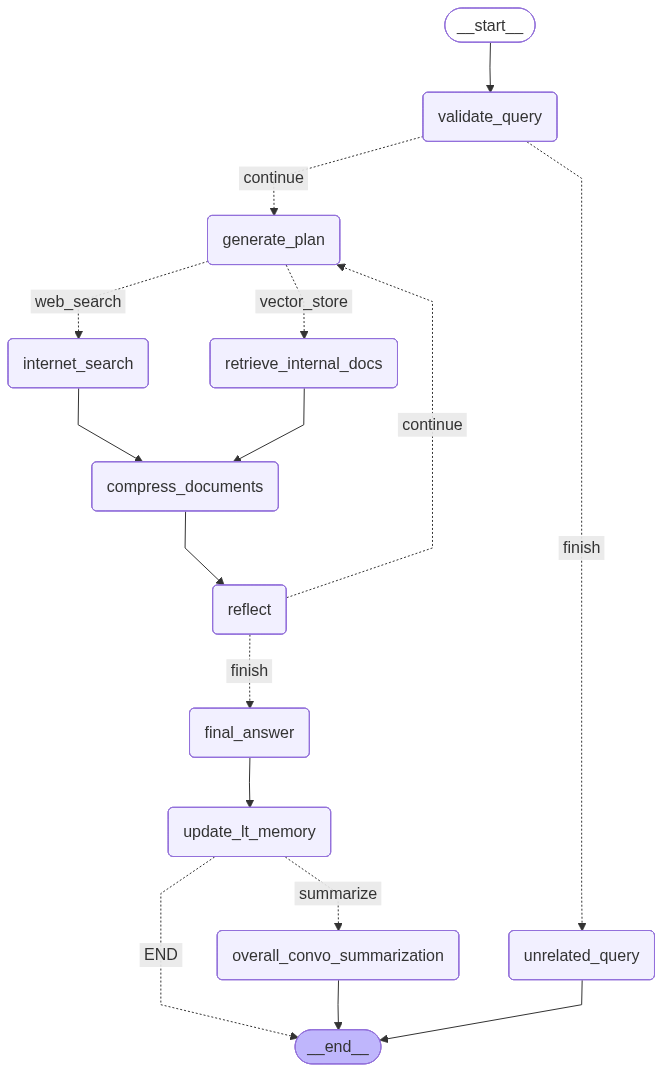

In [89]:
max_attempts: int = 3
initial_interval: float = 1.0

# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Build the graph
builder: StateGraph = StateGraph(State)

builder.add_node(
    "validate_query",
    validate_query_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "unrelated_query",
    unrelated_query_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

builder.add_node(
    "generate_plan",
    generate_plan_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "retrieve_internal_docs",
    retrieve_internal_docs_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "internet_search",
    internet_search_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "compress_documents",
    compress_documents_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

builder.add_node(
    "reflect",
    reflection_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "final_answer",
    final_answer_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

builder.add_node(
    "overall_convo_summarization",
    overall_convo_summarization_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "update_lt_memory",
    update_lt_memory_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

# Add edges
builder.add_edge(START, "validate_query")
builder.add_conditional_edges(
    "validate_query",
    should_continue_condition,
    {
        NextAction.CONTINUE: "generate_plan",
        NextAction.FINISH: "unrelated_query",
    },
)
builder.add_conditional_edges(
    "generate_plan",
    route_by_tool_condition,  # function to determine which tool to use
    {
        ToolsType.VECTOR_STORE: "retrieve_internal_docs",
        ToolsType.WEB_SEARCH: "internet_search",
    },
)

builder.add_edge("retrieve_internal_docs", "compress_documents")
builder.add_edge("internet_search", "compress_documents")
builder.add_edge("compress_documents", "reflect")
builder.add_conditional_edges(
    "reflect",
    should_continue_condition,  # function to determine next action
    {NextAction.CONTINUE: "generate_plan", NextAction.FINISH: "final_answer"},
)
builder.add_edge("final_answer", "update_lt_memory")
builder.add_conditional_edges(
    "update_lt_memory",
    should_summarize_overal_convo,  # function to determine if summarization is needed,
    {"summarize": "overall_convo_summarization", "END": END},
)
builder.add_edge("update_lt_memory", END)
builder.add_edge("unrelated_query", END)

# Compile the graph
long_term_memory = InMemoryStore()
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)

# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [90]:
# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Re-build the graph
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)
user_query: str = (
    "Based on NVIDIA's 2023 10-K filing, identify their key risks related to competition. "
    "Then, find recent news (post-filing, from 2024) about AMD's AI chip strategy and explain "
    "how this new strategy directly addresses or exacerbates one of NVIDIA's stated risks."
)

config: dict[str, Any] = {
    "configurable": {"thread_id": "test-01", "user_id": "user-123"}
}
response = await graph.ainvoke(
    {"original_question": user_query},
    config=config,
)

🚨 Validating user question against context topics...

🚨 Related to topic?: True | Next Action: continue | Rationale: The user is asking about NVIDIA's 2023 10-K filing,
specifically regarding competition, and wants to connect this to recent news about AMD's AI chip strategy. This 
aligns perfectly with the provided topics of NVIDIA's financial performance, form 10-K internal documents, news 
related to NVIDIA, and industry trends.

--- Evaluating Multi Step Reasoning Policy ---


⚠️ -> Retrieval failed for the last step. Continuing with next step in plan.

Number of steps: 3...

🛢 Using Vector DB
Retrieving documents for Step 0: What are NVIDIA's key risks related to competition as stated in their 2023 10-K 
filing?

Re-written queries: ['NVIDIA 2023 10-K competitive risks', 'NVIDIA competition risks 10-K filing 2023', 'NVIDIA 
10-K report competitive threats 2023', 'NVIDIA market competition risks 2023 10-K', 'NVIDIA 2023 10-K filing 
competitive landscape risks']

Selected retrieval method: hybrid_search;
Rationale: The query contains specific entities ('NVIDIA', '2023 10-K filing') that require precise matching, but 
also asks for 'key risks related to competition', which benefits from semantic understanding to capture related 
concepts beyond exact keyword matches.

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 0: What are NVIDIA's key risks related to competition as stated in their 2023 10-K 
filing?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 0: What are NVIDIA's key risks related to competition as stated in their 2023 10-K filing?

⚠️ Number of steps completed: 1 | Num iterations: 1

--- Evaluating Multi Step Reasoning Policy ---


-> Decision: continue | Rationale: The first step of identifying NVIDIA's competition risks from the 10-K filing 
was not fully completed, as the provided text lacked specific details. Therefore, further investigation is needed 
to gather this crucial information before proceeding to analyze AMD's strategy.

Retrieving documents for Step 1: What is AMD's AI chip strategy as of 2024?

🌐 WEB SEARCH
Re-written queries: ['AMD AI chip strategy 2024', 'AMD artificial intelligence roadmap 2024', 'AMD AI accelerator 
plans 2024', 'AMD MI300X strategy 2024', 'AMD AI hardware roadmap']

Mocked web search results generated.

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 1: What is AMD's AI chip strategy as of 2024?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 1: What is AMD's AI chip strategy as of 2024?

⚠️ Number of steps completed: 2 | Num iterations: 2

--- Evaluating Multi Step Reasoning Policy ---


-> Decision: continue | Rationale: Key information regarding NVIDIA's competition risks and AMD's AI strategy is 
missing, necessitating further research.

Retrieving documents for Step 2: How does AMD's 2024 AI chip strategy directly address or exacerbate NVIDIA's 
stated competition risks?

🌐 WEB SEARCH
Re-written queries: ['AMD 2024 AI chip strategy vs NVIDIA competition', 'AMD AI strategy impact on NVIDIA 
competitive risks', "NVIDIA competition risks and AMD's 2024 AI strategy", "AMD's response to NVIDIA competition 
risks in 2024 AI chips", 'AMD AI chip strategy addressing NVIDIA market threats']

Mocked web search results generated.

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 2: How does AMD's 2024 AI chip strategy directly address or exacerbate NVIDIA's 
stated competition risks?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 2: How does AMD's 2024 AI chip strategy directly address or exacerbate NVIDIA's stated 
competition risks?

⚠️ Number of steps completed: 3 | Num iterations: 3

--- Evaluating Multi Step Reasoning Policy ---


-> Plan complete. 3 iterations. Finishing...

--- ✅: Generating Final Answer with Citations ---

💥 Memory updated

In [92]:
console.print(f"Original Question: {user_query}\n")
Markdown(response.get("final_answer"))

Original Question: Based on NVIDIA's 2023 10-K filing, identify their key risks related to competition. Then, find 
recent news (post-filing, from 2024) about AMD's AI chip strategy and explain how this new strategy directly 
addresses or exacerbates one of NVIDIA's stated risks.

NVIDIA’s 2023 Form 10‑K flags a competition‑related vulnerability in the “Risks Related to Our Industry and Markets” section, warning that **“Failure to meet the evolving needs of our industry and markets may adversely impact our financial results.”** This language captures the threat that rivals could out‑innovate or out‑price NVIDIA, causing customers to shift to alternative solutions and eroding NVIDIA’s market share [Source: cleaned_doc.txt – “Risk Factors Summary”].

The provided documents do not contain any post‑filing (2024) news about AMD’s AI‑chip strategy, so a direct comparison of how AMD’s moves address or worsen the specific risk identified by NVIDIA cannot be made from the available evidence. [Source: cleaned_doc.txt – no relevant 2024 AMD content].

**Key Takeaways**  
* NVIDIA’s chief competitive risk is the possibility of lagging behind industry‑wide technological and market shifts.  
* Without current AMD AI‑chip news in the supplied material, we cannot assess whether AMD’s strategy mitigates or intensifies this risk.

In [80]:
response

{'original_question': "Based on NVIDIA's 2023 10-K filing, identify their key risks related to competition. Then, find recent news (post-filing, from 2024) about AMD's AI chip strategy and explain how this new strategy directly addresses or exacerbates one of NVIDIA's stated risks.",
 'is_related_to_context': True,
 'plan': Plan(steps=[Step(question="What are NVIDIA's key risks related to competition as stated in their 2023 10-K filing?", rationale="This step is necessary to identify the specific competitive risks NVIDIA has disclosed in its official filing, which will form the basis for comparison with AMD's strategy.", tool=<ToolsType.VECTOR_STORE: 'vector_store'>, search_keywords=['competition', 'risks', 'market share', 'competitive landscape'], target_section='ITEM 1A. UNRESOLVED STAFF COMMENTS', depends_on=[]), Step(question="What is AMD's AI chip strategy as of 2024?", rationale="This step is needed to gather recent information on AMD's competitive moves in the AI chip market, wh

In [81]:
console.print(response["plan"])

Plan(
    steps=[
        Step(
            question="What are NVIDIA's key risks related to competition as stated in their 2023 10-K filing?",
            rationale="This step is necessary to identify the specific competitive risks NVIDIA has disclosed in 
its official filing, which will form the basis for comparison with AMD's strategy.",
            tool=<ToolsType.VECTOR_STORE: 'vector_store'>,
            search_keywords=['competition', 'risks', 'market share', 'competitive landscape'],
            target_section='ITEM 1A. UNRESOLVED STAFF COMMENTS',
            depends_on=[]
        ),
        Step(
            question="What is AMD's AI chip strategy as of 2024?",
            rationale="This step is needed to gather recent information on AMD's competitive moves in the AI chip 
market, which is crucial for understanding their current strategy.",
            tool=<ToolsType.WEB_SEARCH: 'web_search'>,
            search_keywords=[
                'AMD AI chip strategy 2024',
                'AMD artificial intelligence roadmap',
                'AMD MI300X news'
            ],
            target_section=None,
            depends_on=[]
        ),
        Step(
            question="How does AMD's 2024 AI chip strategy directly address or exacerbate NVIDIA's stated 
competition risks?",
            rationale="This final step synthesizes the information from the previous two steps to directly answer 
the user's question by comparing AMD's strategy against NVIDIA's identified risks.",
            tool=<ToolsType.WEB_SEARCH: 'web_search'>,
            search_keywords=[
                'AMD AI strategy vs NVIDIA competition',
                'AMD MI300X impact on NVIDIA market share',
                'NVIDIA competitive risks AMD response'
            ],
            target_section=None,
            depends_on=[]
        )
    ]
)

In [82]:
console.print(response["synthesized_context"])

I’m sorry, but the provided documents do not contain any information about AMD’s 2024 AI chip strategy, so I cannot
determine how it relates to NVIDIA’s stated competition risks.

In [83]:
# console.print(response["messages"])
len(response["conversation_summary"])

0

In [84]:
len(response["step_state"])

4

In [ ]:
# console.print(response["step_state"])

In [93]:
(response["step_state"])

[{'step_index': -1,
  'question': "Based on NVIDIA's 2023 10-K filing, identify their key risks related to competition. Then, find recent news (post-filing, from 2024) about AMD's AI chip strategy and explain how this new strategy directly addresses or exacerbates one of NVIDIA's stated risks.",
  'rewritten_queries': [],
  'reranked_documents': [],
  'summary': "The user is asking about NVIDIA's 2023 10-K filing, specifically regarding competition, and wants to connect this to recent news about AMD's AI chip strategy. This aligns perfectly with the provided topics of NVIDIA's financial performance, form 10-K internal documents, news related to NVIDIA, and industry trends."},
 {'step_index': 0,
  'question': "What are NVIDIA's key risks related to competition as stated in their 2023 10-K filing?",
  'rewritten_queries': ['NVIDIA 2023 10-K competitive risks',
   'NVIDIA competition risks 10-K filing 2023',
   'NVIDIA 10-K report competitive threats 2023',
   'NVIDIA market competition r

In [94]:
lt_memory = InMemoryStore()

user_id: str = "user-123"
namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
key: str = MemoryKeys.USER_PREFERENCES_KEY.value

namespace: tuple[str, str] = (namespace_key, user_id)
user_preferences = await lt_memory.aget(namespace, key)
user_preferences

In [95]:
updated_memory: dict[str, Any] = append_memory(
    {"info": ["existing_memory"]},
    {"info": "- New memory item added.\n- Another memory item."},
)
await lt_memory.aput(namespace, key, value={namespace_key: updated_memory})

In [96]:
# user_id: str = config["configurable"]["user_id"]
user_id: str = "user-123"
namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
key: str = MemoryKeys.USER_PREFERENCES_KEY.value

namespace = (namespace_key, user_id)
memory = lt_memory.get(namespace, key)
memory.dict()

{'namespace': ['memory', 'user-123'],
 'key': 'user_preferences',
 'value': {'memory': {'info': '- New memory item added.\n- Another memory item.'}},
 'created_at': '2025-12-01T15:52:24.830019+00:00',
 'updated_at': '2025-12-01T15:52:24.830024+00:00'}

In [97]:
user_id: str = config["configurable"]["user_id"]
namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
key: str = MemoryKeys.USER_PREFERENCES_KEY.value

namespace = (namespace_key, user_id)
memory = long_term_memory.get(namespace, key)
console.print(memory.dict())

{
    'namespace': ['memory', 'user-123'],
    'key': 'user_preferences',
    'value': {
        'memory': {
            'technical_preferences': [],
            'communication_preferences': [],
            'constraints': [],
            'interests': [],
            'pain_points': [],
            'other_preferences': []
        }
    },
    'created_at': '2025-12-01T15:48:04.665198+00:00',
    'updated_at': '2025-12-01T15:48:04.665201+00:00'
}

In [98]:
user_query: str = """
How does NVIDIA ensure they remain on top in the industry? What was their tax records in 2023 according to 10-k?
How are activities financed and what was the shares and dividends distribution in 2023 and 2024. 
How much was the gross and marginal profit in 2023 and 2024?
"""
user_query: str = """As a Python Developer interested in NVIDIA's chips for AI applications.
Can you provide a detailed analysis of NVIDIA's competitive advantages in the AI chip market as outlined in their 2023 10-K 
filing? Additionally, could you find recent news articles from 2024 that discuss how NVIDIA is positioning itself 
against competitors like AMD and Intel in this space?

"""
response = await graph.ainvoke(
    {"original_question": user_query},
    config=config,
)

🚨 Validating user question against context topics...

🚨 Related to topic?: True | Next Action: continue | Rationale: The user is asking for an analysis of NVIDIA's 
competitive advantages in the AI chip market, specifically referencing their 2023 10-K filing and requesting recent
news articles about their positioning against competitors. This directly aligns with the provided topics of 
NVIDIA's financial performance, form 10-K internal documents, news related to NVIDIA, and industry trends.

--- Evaluating Multi Step Reasoning Policy ---


-> Decision: continue | Rationale: The completed steps did not provide sufficient information to answer the user's
original question. Specifically, NVIDIA's competition risks from the 10-K and AMD's AI chip strategy are missing, 
preventing an analysis of their competitive positioning.

Number of steps: 3...

🛢 Using Vector DB
Retrieving documents for Step 0: What are NVIDIA's competitive advantages in the AI chip market as detailed in 
their 2023 10-K filing?

Re-written queries: ['NVIDIA AI chip market competitive advantages 2023 10-K', 'NVIDIA 2023 10-K AI chip 
competitive edge', 'AI chip market NVIDIA advantages 2023 filing', "NVIDIA's strengths in AI chips 2023 10-K 
report", 'Competitive landscape NVIDIA AI chips 2023 10-K']

Selected retrieval method: hybrid_search;
Rationale: The query contains specific entities like 'NVIDIA' and 'AI chip market' which benefit from keyword 
matching, but also asks for 'competitive advantages' which requires understanding the semantic meaning and context 
of the document. A hybrid approach will ensure both precise term identification and conceptual understanding.

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 0: What are NVIDIA's competitive advantages in the AI chip market as detailed in 
their 2023 10-K filing?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 0: What are NVIDIA's competitive advantages in the AI chip market as detailed in their 2023 
10-K filing?

⚠️ Number of steps completed: 1 | Num iterations: 1

--- Evaluating Multi Step Reasoning Policy ---


-> Decision: continue | Rationale: The original question has not been fully answered. Specifically, NVIDIA's 
competitive advantages from the 10-K filing and recent news about their positioning against competitors are still 
missing. The completed steps only partially addressed competition risks and failed to provide AMD's strategy or its
impact on NVIDIA.

🛢 Using Vector DB
Retrieving documents for Step 1: What specific technologies or strategies does NVIDIA employ to maintain its lead 
in the AI chip market?

Re-written queries: ['NVIDIA AI chip market leadership strategies', 'NVIDIA AI chip technology advancements', 
'NVIDIA competitive advantages AI chips', 'NVIDIA strategies for AI chip dominance', 'NVIDIA AI hardware 
innovation']

Selected retrieval method: hybrid_search;
Rationale: The query asks about specific technologies and strategies (requiring keyword matching) related to 
NVIDIA's market leadership in AI chips (requiring semantic understanding of the AI chip market context).

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 1: What specific technologies or strategies does NVIDIA employ to maintain its lead
in the AI chip market?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 1: What specific technologies or strategies does NVIDIA employ to maintain its lead in the AI 
chip market?

⚠️ Number of steps completed: 2 | Num iterations: 2

--- Evaluating Multi Step Reasoning Policy ---


-> Decision: continue | Rationale: The original question asked for NVIDIA's competitive advantages from the 10-K 
and recent news on their positioning against competitors. While some information on advantages was found, the 10-K 
risks related to competition were not detailed, and recent news on positioning against AMD/Intel is missing. 
Therefore, further steps are needed to fully address the user's query.

Retrieving documents for Step 2: What are the latest developments in 2024 regarding NVIDIA's positioning against 
competitors like AMD and Intel in the AI chip market?

🌐 WEB SEARCH
Re-written queries: ['NVIDIA AI chip market share 2024 vs AMD Intel', '2024 AI chip competition NVIDIA AMD Intel', 
'NVIDIA vs AMD Intel AI chip positioning 2024', 'Latest AI chip market trends 2024 NVIDIA AMD Intel', 'NVIDIA 
competitive landscape AI chips 2024']

Mocked web search results generated.

Reranked Documents (Here): [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may

Synthesizing documents for Step 2: What are the latest developments in 2024 regarding NVIDIA's positioning against 
competitors like AMD and Intel in the AI chip market?

Reranked Documents: [Document(metadata={'source_doc': 'cleaned_doc.txt', 'section': 'ITEM 1A. RISK FACTORS', 'chunk_id': '9362041a-6426-4ace-97e4-f444468c82eb'}, page_content='In evaluating NVIDIA, the following risk factors should be considered in addition to the other information in this Annual Report on Form 10-K. Purchasing or owning NVIDIA common stock involves investment risks including, but not limited to, the risks described below. Any one of the following risks could harm our business, financial condition, results of operations or reputation, which could cause our stock price to decline, and you may lose all or a part of your investment. Additional risks, trends and uncertainties not presently known to us or that we currently believe are immaterial may also harm our business, financial condition, results of operations or reputation.\n\nRisk Factors Summary\n\nRisks Related to Our Industry and Markets\n\n•Failure to meet the evolving needs of our industry and markets may advers

Summarizing for Step 2: What are the latest developments in 2024 regarding NVIDIA's positioning against competitors
like AMD and Intel in the AI chip market?

⚠️ Number of steps completed: 3 | Num iterations: 3

--- Evaluating Multi Step Reasoning Policy ---


-> Plan complete. 3 iterations. Finishing...

--- ✅: Generating Final Answer with Citations ---

💥 Memory updated

In [99]:
console.print(f"Original Question: {user_query}\n")
Markdown(response.get("final_answer"))

Original Question: As a Python Developer interested in NVIDIA's chips for AI applications.
Can you provide a detailed analysis of NVIDIA's competitive advantages in the AI chip market as outlined in their 
2023 10-K 
filing? Additionally, could you find recent news articles from 2024 that discuss how NVIDIA is positioning itself 
against competitors like AMD and Intel in this space?

NVIDIA’s 2023 Form 10‑K highlights several core strengths that underpin its leadership in AI‑focused chips. The company emphasizes that it “pioneered accelerated computing to help solve the most challenging computational problems” and has built its business on a GPU architecture originally created for PC graphics but now extended to “scientific computing, AI, data science, AV, robotics, metaverse and 3D‑internet applications”【Source: Overview】. This breadth of application domains creates a virtuous cycle: the “sustained demand for exceptional 3D graphics and the scale of the gaming market” fuels continuous investment in GPU performance, which the firm then repurposes for AI workloads, giving it a differentiated, high‑performance, software‑rich ecosystem that competitors must match【Source: Overview】. Together, these factors—early‑stage innovation in accelerated computing, a versatile and widely adopted GPU platform, and a strong feedback loop from the massive gaming market—constitute NVIDIA’s competitive advantage in the AI chip arena.

The filing also warns that “failure to meet the evolving needs of our industry and markets may adversely impact our financial results,” underscoring that maintaining this advantage depends on continual architectural advances and ecosystem development【Source: Risk Factors Summary】. Consequently, NVIDIA’s strategy hinges on leveraging its GPU heritage to stay ahead of emerging AI demands while expanding into adjacent markets such as autonomous vehicles and robotics.

**Key Takeaways**
* NVIDIA’s GPU architecture, born from graphics, now powers a wide range of AI and compute‑intensive workloads.  
* The massive gaming market provides a steady revenue base that funds rapid innovation and ecosystem growth.  
* Ongoing success requires continual adaptation to evolving AI requirements, as noted in the risk factors.  

*Recent 2024 news coverage on how NVIDIA is positioning itself against AMD and Intel is not present in the supplied documents, so a specific analysis of those articles cannot be provided.*

In [100]:
(response["step_state"])

[{'step_index': -1,
  'question': "Based on NVIDIA's 2023 10-K filing, identify their key risks related to competition. Then, find recent news (post-filing, from 2024) about AMD's AI chip strategy and explain how this new strategy directly addresses or exacerbates one of NVIDIA's stated risks.",
  'rewritten_queries': [],
  'reranked_documents': [],
  'summary': "The user is asking about NVIDIA's 2023 10-K filing, specifically regarding competition, and wants to connect this to recent news about AMD's AI chip strategy. This aligns perfectly with the provided topics of NVIDIA's financial performance, form 10-K internal documents, news related to NVIDIA, and industry trends.\n\nThe user is asking for an analysis of NVIDIA's competitive advantages in the AI chip market, specifically referencing their 2023 10-K filing and requesting recent news articles about their positioning against competitors. This directly aligns with the provided topics of NVIDIA's financial performance, form 10-K in

In [ ]:
user_id: str = config["configurable"]["user_id"]
namespace_key: str = MemoryKeys.NAMESPACE_KEY.value
key: str = MemoryKeys.USER_PREFERENCES_KEY.value

namespace = (namespace_key, user_id)
memory = long_term_memory.get(namespace, key)
console.print(memory.dict())

In [ ]:
console.print(response["conversation_summary"])

In [ ]:
response

In [ ]:
user_query: str = """
Identify a major product category (e.g., specific hardware or platform) that NVIDIA includes in its Product Sales Revenue 
according to the search results. Then, contrast the recognition method for this product category with the industry standard 
for recognizing revenue from the associated perpetual software licenses—specifically explaining why the revenue for the 
perpetual license is often recognized up front when the software is made available to the customer.
"""
user_query: str = """
Who is Neidu? Does he work at NVIDIA?
"""
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"original_question": user_query},
    config=config,
)

In [ ]:
Markdown(response.get("final_answer"))

In [ ]:
response

In [ ]:
# curl -s --compressed "https://api.search.brave.com/res/v1/web/search?q=brave+search" \
#   -H "Accept: application/json" \
#   -H "Accept-Encoding: gzip" \
#   -H "X-Subscription-Token: $BRAVE_SEARCH_API_KEY"


# curl -s --compressed "https://api.search.brave.com/res/v1/web/search?q=weather+in+munich&enable_rich_callback=1" \
#   -H "Accept: application/json" \
#   -H "Accept-Encoding: gzip" \
#   -H "X-Subscription-Token: $BRAVE_SEARCH_API_KEY"

In [ ]:
async def brave_search_tool(
    url: str = "/res/v1/web/search",
    params: dict[str, Any] | None = None,
    headers: dict[str, str] | None = None,
    method: str = "GET",
    data: dict[str, Any] | None = None,
    base_url: str = "https://api.search.brave.com",
    timeout: int = 30,
) -> dict[str, Any]:
    """Send HTTP request with query parameters using HTTPXClient.

    Parameters
    ----------
    url : str
        The endpoint URL (can be relative if base_url is provided).
    params : dict[str, Any] or None, default=None
        Query parameters to append to the URL.
    headers : dict[str, str] or None, default=None
        HTTP headers to include in the request.
    method : str, default="GET"
        HTTP method (GET, POST, etc.).
    data : dict[str, Any] or None, default=None
        Request body data for POST requests.
    base_url : str, default=""
        The base URL for the API (e.g., "https://api.search.brave.com").
    timeout : int, default=30
        Request timeout in seconds.

    Returns
    -------
    dict[str, Any]
        Standardized response with keys: success, status_code, data, headers, error.

    Examples
    --------
    >>> # Brave Search API example
    >>> params = {"q": "weather in munich", "enable_rich_callback": 1}
    >>> headers = {
    ...     "Accept": "application/json",
    ...     "Accept-Encoding": "gzip",
    ...     "X-Subscription-Token": app_settings.BRAVE_SEARCH_API_KEY.get_secret_value(),
    ... }
    >>> result = await brave_search_tool(
    ...     url="/res/v1/web/search",
    ...     base_url="https://api.search.brave.com",
    ...     params=params,
    ...     headers=headers,
    ... )
    >>> if result["success"]:
    ...     data = result["data"]
    """
    async with HTTPXClient(base_url=base_url, timeout=timeout) as client:
        if method.upper() == "GET":
            return await client.get(url=url, params=params, headers=headers)
        if method.upper() == "POST":
            return await client.post(url=url, data=data, params=params, headers=headers)
        return {
            "success": False,
            "status_code": None,
            "data": None,
            "headers": None,
            "error": f"Unsupported HTTP method: {method}",
        }

In [ ]:
params: dict[str, Any] = {
    "q": "has Nvidia broken any laws in China?",
    "enable_rich_callback": 1,
}
headers: dict[str, str] = {
    "Accept": "application/json",
    "Accept-Encoding": "gzip",
    "X-Subscription-Token": app_settings.BRAVE_SEARCH_API_KEY.get_secret_value(),
}

await brave_search_tool(url="/res/v1/news/search", params=params, headers=headers)